# Purpose of this Collab

In this Google Collaboratory document, different implementations of Support Vector Machines will be exploited. Thes implementations will be based on the creation and training of SVMs created from scratch but also others based on the scikit-learn library or source code found in documentation pages.

The end-goal of this collab is to get familiar with SVM as a powerful machine learning algorithm, to understand its strenght and weaknesses as well as the maths behind it.


**Importing libraries and dependencies**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import time
from skimage.feature import hog
from skimage import data, exposure

**Downloading the cifar-10 dataset by using keras datasets**

In [ ]:
# Downloading the dataset (CIFAR-10) using keras datasets
from keras.datasets import cifar10
def load_dataset():
 # load dataset
 (X_train,y_train),(X_test,y_test) = cifar10.load_data()
 return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = load_dataset()

170498071/170498071 [==============================] - 2s 0us/step


**Data Normalization - as performed in most image datasets**

In [ ]:
# We know that the pixels in each image is between no colour and full color and thus [0,255]
# We also know that normalization can help neural networks
import keras
def normalization_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

X_train, X_test = normalization_pixels(X_train,X_test)

**Taking Image Subset**

Taking a Subset of the initial training set to reduce the complexity and the training time as SVM needs a lot of training time, which makes gridsearch taking more than 3-4 hours and collab stops working.

In [ ]:
# Taking a subset of the initial dataset since SVMs have a time complexity that is approximately quadratic with the number of samples
def take_subset(X, y, num_of_samples):
  if num_of_samples < X.shape[0]:
    # take a subset by utilizing the train_test_split function of scikit - learn
    X_subset, _, y_subset, _ = train_test_split(X, y, train_size = num_of_samples, stratify = y) # making sure that the subset is stratified
    return X_subset,y_subset
  else:
    return X,y

**Reshaping the Features Vector**

  When using the whole images and not features, we need to make the feature vector have 2 dimensions instead of the 4 dimensions it currently has.
  In the following cell, we are reshaping the Features Vector.

In [ ]:
# Reshape the X_train and X_test data to 2D arrays
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

**Labels Preprocessing - Transformation**


The labels are tranformed to 1d-array in order to be able to be used in scikit-learn implementation without errors.

In [ ]:
# Transforming the labels into a 1d-numpy array according to the documentation of scikit-learn
# The custom implementation will use the following arrays as well.
y_train = y_train.flatten()
y_test = y_test.flatten()

**Dimensionality Reduction using Principal Component Analysis (PCA)**

In this initial Dimensionality Reduction, PCA is utilized in order to keep the 95% of the initial information. This leads to an impressive reduction of the features of the initial dataset.

In [ ]:
# Preprocess our data by using dimensionality reduction/feature selection by implementing PCA
from sklearn.decomposition import PCA

def feature_selection_pca(X_train,X_test):
  # Select the number of features of the dataset that explain 95% of the variance
  pca = PCA(n_components = 0.95, svd_solver='auto', tol=0.0, random_state=None)
  # Fitting and Transforming the training and the testing to reduce the dimensionality of both datasets
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  return X_train_pca,X_test_pca

**Apply PCA**

In [ ]:
# Applying PCA to the initial image flattened (2d) dataset
X_train_2d, X_test_2d = feature_selection_pca(X_train_2d,X_test_2d)

**Feature Extraction** using:

*   Histogram of Oriented Gradies (HOG)
*   Mean RGB Value of pixels
*   Brightness of specific image parts and positions






In [ ]:
def image_feature_extraction(X_train,X_test):
  # Implement Feature Selection using the Pixel Values in the Original Pictures
  # for each pixel the mean value of the 3 channels will be calculated
  def average_pixel_rgbvalue(X_train,X_test):
    X_train_feature_matrix = np.zeros(X_train.shape[:3], dtype=np.float32)
    X_test_feature_matrix = np.zeros(X_test.shape[:3], dtype=np.float32)

    # Loop through the training set and calculate the mean for the 3 channels
    for i in range(X_train_feature_matrix.shape[0]):
        for j in range(X_train_feature_matrix.shape[1]):
            for k in range(X_train_feature_matrix.shape[2]):
                X_train_feature_matrix[i][j][k] = (X_train[i][j][k][0] + X_train[i][j][k][1] + X_train[i][j][k][2]) / 3

    # Loop through the test set and calculate the mean for the 3 channels
    for i in range(X_test_feature_matrix.shape[0]):
        for j in range(X_test_feature_matrix.shape[1]):
            for k in range(X_test_feature_matrix.shape[2]):
                X_test_feature_matrix[i][j][k] = (X_test[i][j][k][0] + X_test[i][j][k][1] + X_test[i][j][k][2]) / 3

    return X_train_feature_matrix,X_test_feature_matrix


  # Calculate the brightness in specific points of each image in the training and testing datasets
  def extract_brightness_features(X_train, X_test):
      train_average_brightness = np.mean(X_train, axis=(1, 2, 3)).reshape(-1,1)
      test_average_brightness = np.mean(X_test, axis=(1, 2, 3)).reshape(-1,1)

      # Calculate brightness at appropriate positions for each image
      def get_position_brightness(images):
          center = images[:, 16, 16]
          top_left = images[:, 0, 0]
          top_right = images[:, 0, 31]
          bottom_left = images[:, 31, 0]
          bottom_right = images[:, 31, 31]
          return center, top_left, top_right, bottom_left, bottom_right

      train_center, train_top_left, train_top_right, train_bottom_left, train_bottom_right = get_position_brightness(X_train)
      test_center, test_top_left, test_top_right, test_bottom_left, test_bottom_right = get_position_brightness(X_test)

      return np.hstack([train_average_brightness,train_center, train_top_left, train_top_right, train_bottom_left, train_bottom_right]), np.hstack([test_average_brightness ,test_center, test_top_left, test_top_right, test_bottom_left, test_bottom_right])

  # Create a function that calculates the histograms of oriented gradients
  def extract_hog_features(X, channel_axis=-1):
      hog_features = []
      # Loop in every image and caclulate the HOG
      for i in range(X.shape[0]):
          image = X[i]
          # Different hyperparameters were given to HOG and the best ones were kept
          hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis= channel_axis)
          hog_features.append(hog_image)

      return np.array(hog_features)


  # Applying the created functions
  X_train_rgb_features,X_test_rgb_features = average_pixel_rgbvalue(X_train,X_test)
  # Reshape the feature arrays to 2D arrays
  X_train_rgb_features = X_train_rgb_features.reshape(X_train_rgb_features.shape[0], -1)
  X_test_rgb_features = X_test_rgb_features.reshape(X_test_rgb_features.shape[0], -1)

  X_train_brightness_features,X_test_brightness_features = extract_brightness_features(X_train, X_test)

  X_train_hogfeatures = extract_hog_features(X_train)
  X_test_hogfeatures = extract_hog_features(X_test)

  # Create new feature vector with the extracted features
  X_train_features = np.hstack([X_train_brightness_features,X_train_rgb_features,X_train_hogfeatures])
  X_test_features = np.hstack([X_test_brightness_features,X_test_rgb_features,X_test_hogfeatures])

  # Perform Principal Component Analysis (PCA) to throw features with less significant predictive power
  X_train_features,X_test_features = feature_selection_pca(X_train_features,X_test_features)

  return X_train_features, X_test_features


In the following cells, we are applying the feature extraction to both the original subset of our dataset and the exctracted 2 classes of the binary classification problem.

In [ ]:
X_train_features, X_test_features = image_feature_extraction(X_train,X_test)

**Creating a Binary Classification Problem for SVM**

Selecting 2 classes for one of the problems that will be solved in this collab which is a Binary Classification Problem using SVM. The custom implementations will be based on this binary classification problem.

In [ ]:
def select_classes(X, y, class1, class2):
    # Find indices of the selected classes
    indices_class1 = np.where(y == class1)[0]
    indices_class2 = np.where(y == class2)[0]

    # Combine the indices and sort them for consistency
    indices = np.sort(np.concatenate([indices_class1, indices_class2]))

    # Filter the data and labels based on the selected indices
    X_selected = X[indices]
    y_selected = np.where(y[indices] == class1, 1, -1)  # Map class1 to 1 and class2 to -1 for later use in the SVM custom implementations

    return X_selected, y_selected

def load_classes(X_train, y_train, X_test, y_test, class1, class2):
    # Select samples for each class from the dataset
    X_train_selected, y_train_selected = select_classes(X_train, y_train, class1, class2)
    X_test_selected, y_test_selected = select_classes(X_test, y_test, class1, class2)

    return X_train_selected, y_train_selected, X_test_selected, y_test_selected

# Specifying the classes and the desired number of samples
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# The indexes to the classes to be kept
class1 = 3 # class "cat"
class2 = 5 # class "dog"

# Create the binary classification problem using the flattened images dataset
X_train_binary, y_train_binary, X_test_binary, y_test_binary = load_classes(X_train_2d, y_train, X_test_2d, y_test, class1, class2)

# Create the binary classification problem using the features dataset
X_train_binary_features, y_train_binary_features, X_test_binary_features, y_test_binary_features = load_classes(X_train_features, y_train, X_test_features, y_test, class1, class2)

print(f"The selected classes represent: {labels[class1]} and {labels[class2]}.")

print("The dimensions for the Flattened Images Dataset: ")

# Print the shapes of the new datasets based on flattened images
print("X_train_selected shape:", X_train_binary.shape)
print("y_train_selected shape:", y_train_binary.shape)
print("X_test_selected shape:", X_test_binary.shape)
print("y_test_selected shape:", y_test_binary.shape)

print("The dimensions for the Features Dataset: ")
# Print the shapes of the new datasets based on features
print("X_train_selected shape:", X_train_binary_features.shape)
print("y_train_selected shape:", y_train_binary_features.shape)
print("X_test_selected shape:", X_test_binary_features.shape)
print("y_test_selected shape:", y_test_binary_features.shape)

The selected classes represent: cat and dog.
The dimensions for the Flattened Images Dataset: 
X_train_selected shape: (10000, 217)
y_train_selected shape: (10000,)
X_test_selected shape: (2000, 217)
y_test_selected shape: (2000,)
The dimensions for the Features Dataset: 
X_train_selected shape: (10000, 242)
y_train_selected shape: (10000,)
X_test_selected shape: (2000, 242)
y_test_selected shape: (2000,)


**Implementing the metrics for the Classification Problem**

The following function is used to calculate different metrics for a multi-class classification problem and will be utilized mainly in the final scikit-learn implementation.

In [ ]:
# Function to calculate and print different classification metrics for comparison of our models
def evaluate_classification_metrics(y_true, y_pred, verbose=True):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, and F1-score for all unique labels
    precision = precision_score(y_true, y_pred, zero_division = 0, average='weighted')
    recall = recall_score(y_true, y_pred, zero_division = 0, average='weighted')
    f1 = f1_score(y_true, y_pred, zero_division = 0, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Generate a classification report
    class_report = classification_report(y_true, y_pred, zero_division = 0)
    if verbose:
      print(f'\tAccuracy: {accuracy}')
      print(f'\tPrecision Weighted: {precision}')
      print(f'\tRecall Weighted: {recall}')
      print(f'\tF1-Score Weighted: {f1}')
    # return a disctionary with all the calculated metrics
    return {
        "Accuracy": accuracy,
        "Weighted Precision": precision,
        "Weighted Recall": recall,
        "Weighted F1 Score": f1,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }

**Linearly Separated Classes Generation**

In the following cells, a linear separated dataset is created in order to test the custom implementations and be able to make related visualizations before using the implementations on our complex dataset, which cannot be visualized.

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Creating a simple dataset to make sure that the algorithms are correctly implemented
X_base, y_base = datasets.make_blobs(

        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=40
    )

# Classes 1 and -1
y_base = np.where(y_base == 0, -1, 1)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.5, random_state=42)

Plotting the simple testing dataset

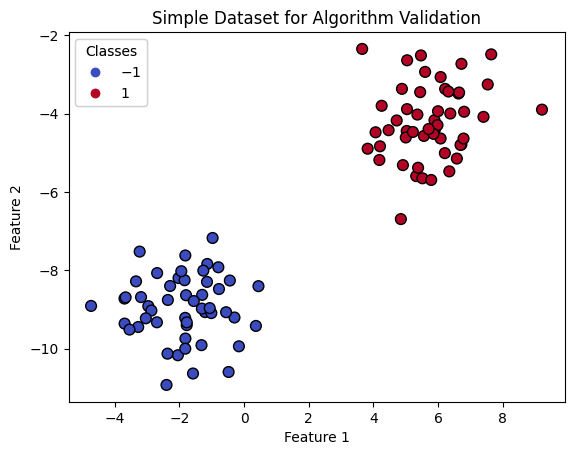

In [ ]:
# Visualizing the scatter plot of the dataset
scatter = plt.scatter(X_base[:, 0], X_base[:, 1], c=y_base, cmap=plt.cm.coolwarm, edgecolors='k', marker='o', s=60)
plt.title("Simple Dataset for Algorithm Validation")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend)
plt.show()

**Subset of the initial Datasets**

In order to be able to explore the SVM algorithm and presents its findings, it is imperative to reduce the time complexity since it is quadratic of the samples. In the initial dataset, each class has 5.000 samples.

In [ ]:
X_train_2d_subset, y_train_2d_subset = take_subset(X_train_2d, y_train, 3000)
X_test_2d_subset, y_test_2d_subset = take_subset(X_test_2d, y_test, 3000)

X_train_features_subset, y_train_features_subset = take_subset(X_train_features, y_train, 3000)
X_test_features_subset, y_test_features_subset = take_subset(X_test_features, y_test, 3000)

X_train_binary_subset, y_train_binary_subset = take_subset(X_train_binary, y_train_binary, 2000)
X_test_binary_subset,y_test_binary_subset = take_subset(X_test_binary, y_test_binary, 2000)

X_train_binary_features_subset, y_train_binary_features_subset = take_subset(X_train_binary_features, y_train_binary_features, 2000)
X_test_binary_features_subset,y_test_binary_features_subset = take_subset(X_test_binary_features, y_test_binary_features, 2000)

# First Approach to SVM - From Scratch
In this first approach, the **Support Vector Machine Algorithm (SVM)** is implemented using built-in python libraries such as numpy and cvxopt, a library used for Convex Optimization.

These approaches are created in order to understand the mathematics behind Support Vector Machines and the reason that they are powerful classifiers.


**CVXOPT IMPLEMENTATION**

In [ ]:
!pip install cvxopt
import cvxopt
from cvxopt import matrix, solvers

The following photo is a representation of the Standard form of quadratic programming. This is the problem we are going to solve using the cvxopt library.The existence of many inequalities and equalities make the problem difficult to be solved without the use of cvxopt.

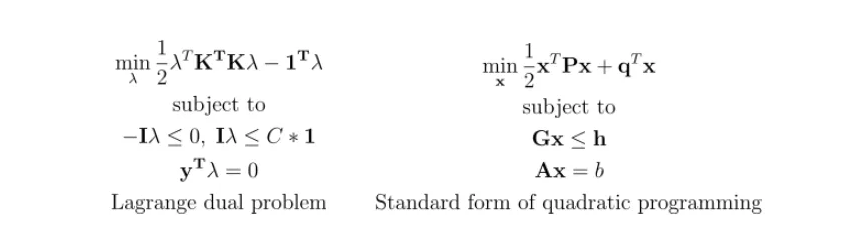

The following is a 2-class SVM implementation using cvxopt for quadratic programming. The code has comments based on material found in the documentation of the library https://cvxopt.org/, and how it applies to our problem.

In [ ]:
# implementation of linear kernel
def linear_kernel(x, y):
  return np.dot(x, y)
# implementation of polynomial kernel
def polynomial_kernel(x, y, p=3):
  return (1 + np.dot(x, y)) ** p
# implementation of gaussian(rbf) kernel
def gaussian_kernel(x, y, sigma = 1.0):
  return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class Support_Vector_Machines_cvxopt:
    def  __init__(self, kernel = linear_kernel, C = None, p = None, sigma = None):
      self.kernel = kernel # specifying the type of kernel that is going to be utilized
      self.C = C # if C is None, then we will have Hard Margin SVM
      self.p = p # applies only to polynomial kernels
      self.sigma = sigma # applies only to gaussian kernels
      # Condition to check if we apply Soft Margin SVM
      if self.C is not None:
        self.C = float(self.C)
      # Some custom conditions to handle default values
      # Setting a default value to the power value of the polynomial kernel in case it
      # has not been initialized
      if kernel == polynomial_kernel and p == None:
        self.p = 3
      # Setting a default value to the sigma value of the sigma kernel in case it
      # has not been initialized
      if kernel == gaussian_kernel and sigma == None:
        self.sigma = 1.0

      # Here I am noting that sigma and p are considered hyperparameters of my classification problem
      # and their optimal value should be searched for.

    def fit(self, X_train, y_train):
      n_samples, n_features = X_train.shape

      # The Quadratic Function is: minimize 1/2 * ΣiΣj αi*αj*yi*yj*K(xi,xj) - Σi αi  (-> also seen as 1/2*trasponse(x)*P*x + transpose(q)*x)
      # subject to  Σi ai*yi = 0  (-> also seen as Ax=b)
      # and  0<= ai <= C (->also seen as Gx<=h)

      # Calculate Gram Matrix based on the chosen kernel function
      # The gram matrix is calculated by creating the matrix with all the dot products
      # between all pairs of data points in the training set.
      # It will be used for the quadratic programming task.
      start = time.time()
      K = np.zeros((n_samples, n_samples))
      for i in range(n_samples):
          for j in range(n_samples):
              if self.kernel is linear_kernel:
                  K[i,j] = self.kernel(X_train[i], X_train[j])
              elif self.kernel is gaussian_kernel:
                  K[i,j] = self.kernel(X_train[i], X_train[j], self.sigma)
              elif self.kernel is polynomial_kernel:
                  K[i,j] = self.kernel(X_train[i], X_train[j], self.p)
      end = time.time()

      print("Gram matrix elapsed time: {}s\n".format(end-start))
      # According to bibliography, we expect Gram matrix calculation to be a computational expensive task as seen by the loops.

      # Formulate the matrices of the QP problem
      # The QP problem we are solving is finding the optimal hyperplane that separates
      # the classes in the feature space.
      P = matrix(np.outer(y_train,y_train) * K) # P is the matrix of the quadratic objective function -> yi*yj*K(xi,xj)
      q = matrix(np.ones(n_samples) * -1.0) # q is the vector of the linear objective function -> all elements are -1
      A = matrix(y_train.astype('double'), (1,n_samples)) # A is the equality constraint matrix, coefficients of Lagrange multipliers -> Ai = yi
      b = matrix(0.0) # b is the equality constraint vector, right side of equality constaints, always zero -> b = 0

      # In the following if-else condition I calculate
      # G which is the inequality constaint matrix and
      # h which is the inequality constaint vector
      # the following are used to solve the inequalities 0<=ai<=C

      # If it is a hard margin
      if self.C is None:
          G = matrix(np.diag(np.ones(n_samples) * -1))
          h = matrix(np.zeros(n_samples))
      else: # if it is a soft margin
          G_1 = -1*np.identity(n_samples)
          G_2 = np.identity(n_samples)
          G = matrix(np.vstack((G_1, G_2))) # G is the traspose of [-I I]
          h_1 = np.zeros(n_samples)
          h_2 = np.ones(n_samples) * self.C
          h = matrix(np.hstack((h_1, h_2))) # h is the transpose of [0 C]

      # Solve QP problem
      start = time.time()
      solvers.options['show_progress'] = False
      # quadratic programmer(qp) solver used
      solution = solvers.qp(P, q, G, h, A, b, )
      end = time.time()

      print("QP solver elapsed time: {}s\n".format(end-start))

      # Lagrange multipliers are obtained below to identify the support vectors
      a = np.ravel(solution['x'])

      # Find Support Vectors -> non-zero Lagrange multipliers because
      # data points with zero Lagrange multipliers lie outside the margin
      # and do not influence the decision boundary
      sv = a > 1e-4 # boolean vector
      self.a = a[sv]
      self.sv = X_train[sv]
      self.sv_y = y_train[sv]
      ind = np.arange(len(a))[sv] # Getting the indices of suppo|rt vectors in the array a

      # Bias (calculated for each support vector and then we take the mean for numerical stability reasons)
      self.b = 0.0 # 0.0 and not 0 in order not to have problem with the values type
      for n in range(len(self.a)):
          self.b += self.sv_y[n]
          self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
      self.b /= len(self.a) # b = (1/number_of_support_vectors) * Σ (yi - Σ ai*yi*K(xi,xj))

    # making predictions using the function below, based on the Lagrange multipliers,
    # the support vectors and the bias learnt.
    def predict(self, X_test):
        start = time.time()
        y_pred = np.zeros(len(X_test))
        # The following code is based on the fact that the decision function for an SVM
        # can be expressed as: f(x) =  Σ{λi * yi * K(x,xi)} + b
        # where the sum is over the number of support vectors and
        # λi are the Lagrange multiplies calculated
        # yi the corresponding class labels
        # K(x,xi) the kernel function
        for i in range(len(X_test)):
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                if self.kernel is linear_kernel:
                    y_pred[i] += a * sv_y * self.kernel(X_test[i], sv)
                elif self.kernel is gaussian_kernel:
                    y_pred[i] += a * sv_y * self.kernel(X_test[i], sv, self.sigma)
                elif self.kernel is polynomial_kernel:
                    y_pred[i] += a * sv_y * self.kernel(X_test[i], sv, self.p)
        y_pred += self.b

        end = time.time()

        print("Testing elapsed time: {}s\n".format(end-start))

        return np.sign(y_pred).astype(int)

One of the main problems with the implementation above, that is faced in many custom SVM implementations searched, is the complexity and resources needed for creating and storing the GRAM Matrix when dealing with high-dimensional data. As it is clear with the following experiments, a lot of time is needed for fitting the SVM model and calculating its parameters. The time needed increases exponentially with the number of samples, and that is the reason that we take a subset of the initial dataset. Approaches that use the full initial dataset could not finish in less than 1 hour and 30 minutes.


**Plotting in 2D**

Function to plot the decision boundaries of the model

In [ ]:
# Function for plotting the decision boundaries created by a classifier -- available only when there are 2 features -- 2d plot
def plot_decision_boundary(X, y, svm_model, title):
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm_model.predict(points)

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', marker='o', s=60)

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend)

    plt.show()

In [ ]:
# Function used for plotting the hyperparameter exploration process
def metrics_plotting(metrics_results,hyperparameter_values,type_of_kernel,hyperparameter):
  # Plotting some of the metrics calculated above
  figsize = (15, 6)
  plt.figure(figsize=figsize)
  # Plotting Accuracy
  plt.subplot(1, 2, 1)
  plt.scatter(hyperparameter_values,[metrics["Accuracy"] for metrics in metrics_results], marker='o')
  plt.title(type_of_kernel + ' Kernel: Accuracy vs ' + hyperparameter)
  plt.xlabel(hyperparameter +' value')
  plt.ylabel('Accuracy')

  # Plotting F1-Score
  plt.subplot(1, 2, 2)
  plt.scatter(hyperparameter_values,[metrics["Weighted F1 Score"] for metrics in metrics_results], marker='o')
  plt.title(type_of_kernel + ' Kernel: F1-Score vs ' + hyperparameter)
  plt.xlabel(hyperparameter +' value')
  plt.ylabel('Weighted F1-Score')

  plt.tight_layout()
  plt.show()


  plt.figure()
  plt.scatter(hyperparameter_values,[metrics["Training Time"] for metrics in metrics_results], marker='o')
  plt.title(type_of_kernel + ' Kernel: Training Time vs ' + hyperparameter)
  plt.xlabel(hyperparameter +' value')
  plt.ylabel('Training Time')
  plt.show()

**CVXOPT IMPLEMENTATION ON SYNTHETIC DATA**

Gram matrix elapsed time: 0.008646965026855469s

QP solver elapsed time: 0.0047490596771240234s

Testing elapsed time: 0.0006248950958251953s

Testing elapsed time: 3.0720279216766357s



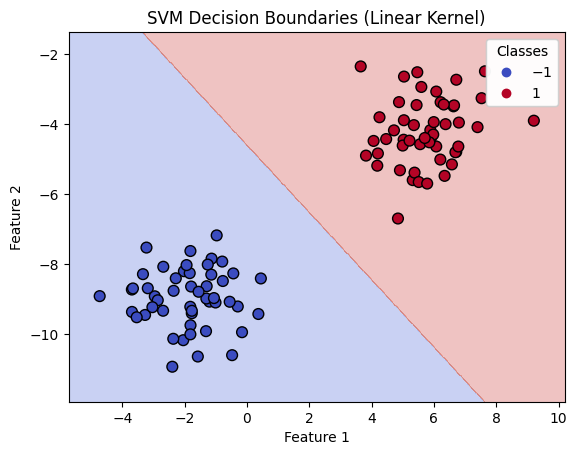

Test set accuracy:  1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        29

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [ ]:
# Initializing a classifier
svc = Support_Vector_Machines_cvxopt(kernel = linear_kernel, C=1.0, sigma=1.0)
# Fitting the model
svc.fit(X_train_base,y_train_base)
# Predicting in the test set
y_pred = svc.predict(X_test_base)
# Plotting decision boundaries in 2d
plot_decision_boundary(X_base, y_base, svc, "SVM Decision Boundaries (Linear Kernel)")
# Plot accuracy and classification report
print('Test set accuracy: ', accuracy_score(y_test_base,y_pred))
print(classification_report(y_test_base, y_pred))

Gram matrix elapsed time: 0.028647422790527344s

QP solver elapsed time: 0.007987737655639648s

Testing elapsed time: 0.01819443702697754s

Testing elapsed time: 75.81118035316467s



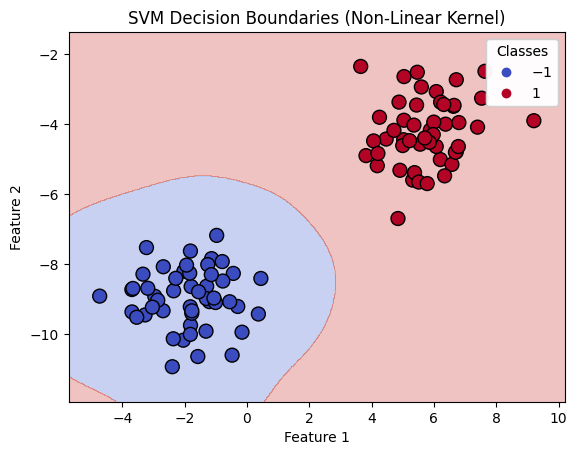

Test set accuracy:  1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        29

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [ ]:
# Initializing a classifier
svc = Support_Vector_Machines_cvxopt(kernel = gaussian_kernel, C=1.0, sigma=1.0)
# Fitting the model
svc.fit(X_train_base,y_train_base)
# Predicting in the test set
y_pred = svc.predict(X_test_base)
# Plotting decision boundaries in 2d
plot_decision_boundary(X_base, y_base, svc, "SVM Decision Boundaries (Non-Linear Kernel)")
# Plot accuracy and classification report
print('Test set accuracy: ', accuracy_score(y_test_base,y_pred))
print(classification_report(y_test_base, y_pred))

Gram matrix elapsed time: 0.017594099044799805s

QP solver elapsed time: 0.0276644229888916s

Testing elapsed time: 0.0007770061492919922s

Testing elapsed time: 6.617506742477417s



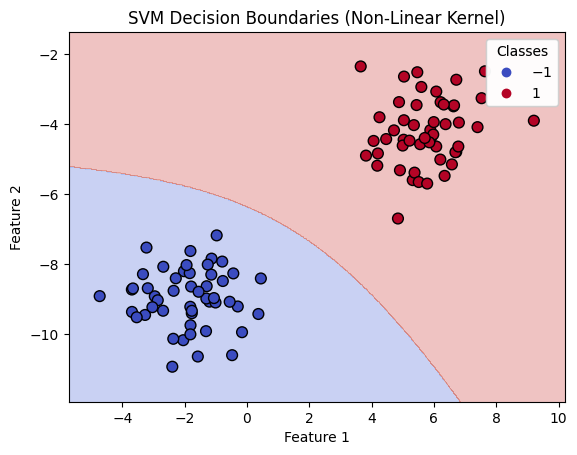

Test set accuracy:  1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        29

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = polynomial_kernel, C=1.0, sigma=1.0, p = 3)
svc.fit(X_train_base,y_train_base)
# Evaluate on test set
y_pred = svc.predict(X_test_base)

plot_decision_boundary(X_base, y_base, svc, "SVM Decision Boundaries (Non-Linear Kernel)")

print('Test set accuracy: ', accuracy_score(y_test_base,y_pred))
print(classification_report(y_test_base, y_pred))

**Experimentation of CVXOPT Implementation on Cifar-10 Dataset**

Experimentation with different kernels in the image dataset.

**Linear Kernel**

In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = linear_kernel, C=1.0, sigma=1.0)

svc.fit(X_train_binary_subset,y_train_binary_subset)

y_pred = svc.predict(X_test_binary_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_subset,y_pred))
print(classification_report(y_test_binary_subset, y_pred))

Gram matrix elapsed time: 9.637509107589722s

QP solver elapsed time: 17.22235679626465s

Testing elapsed time: 10.294341325759888s

Test set accuracy:  0.6015
              precision    recall  f1-score   support

          -1       0.60      0.60      0.60      1000
           1       0.60      0.61      0.60      1000

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000



**Gaussian Kernel**

In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = gaussian_kernel, C=1.0, sigma=1.0)

svc.fit(X_train_binary_subset,y_train_binary_subset)

y_pred = svc.predict(X_test_binary_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_subset,y_pred))
print(classification_report(y_test_binary_subset, y_pred))

Gram matrix elapsed time: 45.851998805999756s

QP solver elapsed time: 10.622393608093262s

Testing elapsed time: 53.73572301864624s

Test set accuracy:  0.5015
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67      1000
           1       1.00      0.00      0.01      1000

    accuracy                           0.50      2000
   macro avg       0.75      0.50      0.34      2000
weighted avg       0.75      0.50      0.34      2000



**Polynomial Kernel**

In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = polynomial_kernel, C=1.0, sigma=1.0, p = 3)

svc.fit(X_train_binary_subset,y_train_binary_subset)

y_pred = svc.predict(X_test_binary_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_subset,y_pred))
print(classification_report(y_test_binary_subset, y_pred))

Gram matrix elapsed time: 26.975677013397217s

QP solver elapsed time: 13.014058351516724s

Testing elapsed time: 0.025056838989257812s

Test set accuracy:  0.4845
              precision    recall  f1-score   support

          -1       0.49      0.73      0.59      1000
           1       0.47      0.24      0.32      1000

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.45      2000
weighted avg       0.48      0.48      0.45      2000



Numerous Experiments were performed on the Images of just 2 classes. However, we can see that the algorithm does not show good results even on the binary classification problem.

 We are going to test what happens when we extract features and test different type of kernels.

**Experimentation on the extracted features**

**Linear Kernel**

In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = linear_kernel, C=1.0, sigma=1.0)

svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)

y_pred = svc.predict(X_test_binary_features_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_features_subset,y_pred))
print(classification_report(y_test_binary_features_subset, y_pred))

Gram matrix elapsed time: 10.770996332168579s

QP solver elapsed time: 15.357488632202148s

Testing elapsed time: 9.783644199371338s

Test set accuracy:  0.6315
              precision    recall  f1-score   support

          -1       0.64      0.61      0.62      1000
           1       0.63      0.65      0.64      1000

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000



**Gaussian Kernel**

In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = gaussian_kernel, C=1.0, sigma=1.0)

svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)

y_pred = svc.predict(X_test_binary_features_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_features_subset,y_pred))
print(classification_report(y_test_binary_features_subset, y_pred))

Gram matrix elapsed time: 45.804863691329956s

QP solver elapsed time: 10.257252216339111s

Testing elapsed time: 49.32582426071167s

Test set accuracy:  0.513
              precision    recall  f1-score   support

          -1       0.51      0.93      0.66      1000
           1       0.57      0.10      0.17      1000

    accuracy                           0.51      2000
   macro avg       0.54      0.51      0.41      2000
weighted avg       0.54      0.51      0.41      2000



**Polynomial Kernel**

In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = polynomial_kernel, C=1.0, sigma=1.0)

svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)

y_pred = svc.predict(X_test_binary_features_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_features_subset,y_pred))
print(classification_report(y_test_binary_features_subset, y_pred))

Gram matrix elapsed time: 25.156602144241333s

QP solver elapsed time: 12.802443265914917s

Testing elapsed time: 2.1816391944885254s

Test set accuracy:  0.504
              precision    recall  f1-score   support

          -1       0.50      0.49      0.50      1000
           1       0.50      0.52      0.51      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



**Hyperparameters' Exploration**

We will now try to understand the effect of every hyperparameter of the cvxopt implementation individually on Accuracy, F1-Score and Training Time of the Support Vector Classifier. The results will be graphed.

**Regularization Parameter (C)**

Gram matrix elapsed time: 11.358216285705566s

QP solver elapsed time: 8.63741397857666s

Testing elapsed time: 26.242948293685913s

	Accuracy: 0.5115
	Precision Weighted: 0.5115060867198749
	Recall Weighted: 0.5115
	F1-Score Weighted: 0.5114353873299743
Gram matrix elapsed time: 28.56093406677246s

QP solver elapsed time: 27.75975513458252s

Testing elapsed time: 15.342502117156982s

	Accuracy: 0.588
	Precision Weighted: 0.5880031681140522
	Recall Weighted: 0.588
	F1-Score Weighted: 0.5879962919666277
Gram matrix elapsed time: 12.28373670578003s

QP solver elapsed time: 13.718240976333618s

Testing elapsed time: 12.02452826499939s

	Accuracy: 0.6485
	Precision Weighted: 0.6485072768565661
	Recall Weighted: 0.6485
	F1-Score Weighted: 0.6484956940722524
Gram matrix elapsed time: 12.340443849563599s

QP solver elapsed time: 15.215564966201782s

Testing elapsed time: 8.448434114456177s

	Accuracy: 0.646
	Precision Weighted: 0.6460584233693478
	Recall Weighted: 0.646
	F1-Score Weighted: 0.

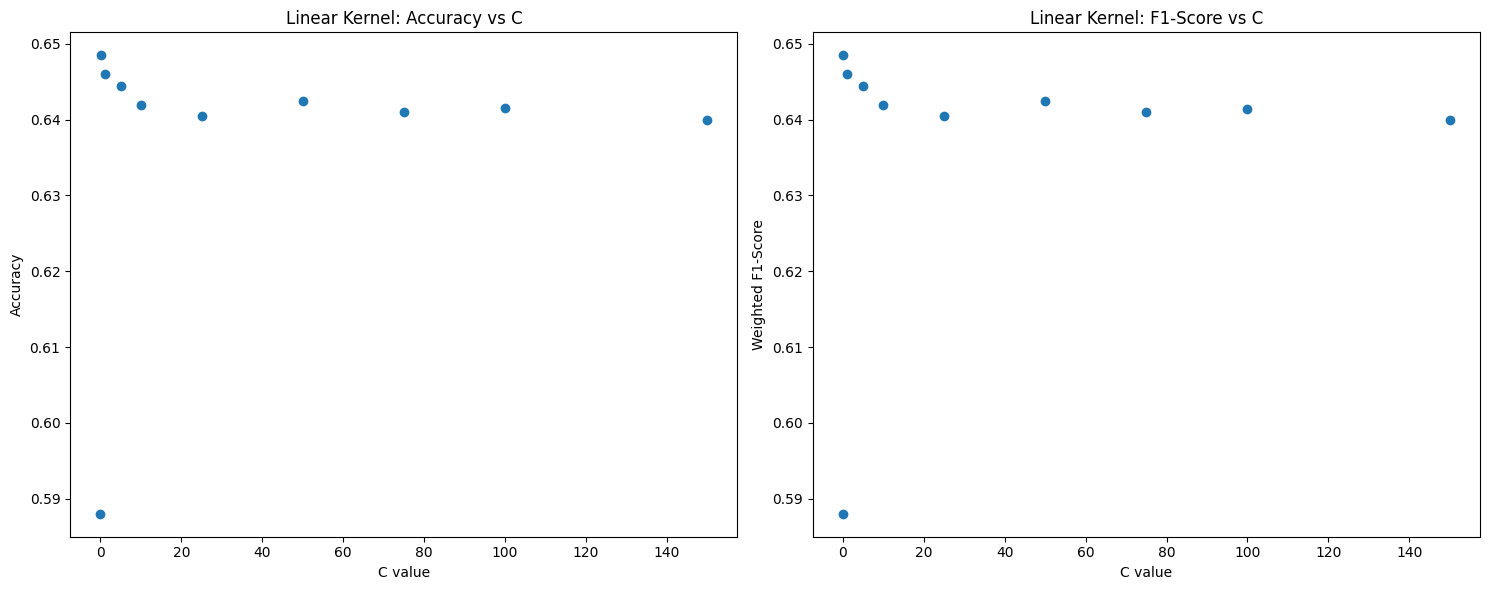

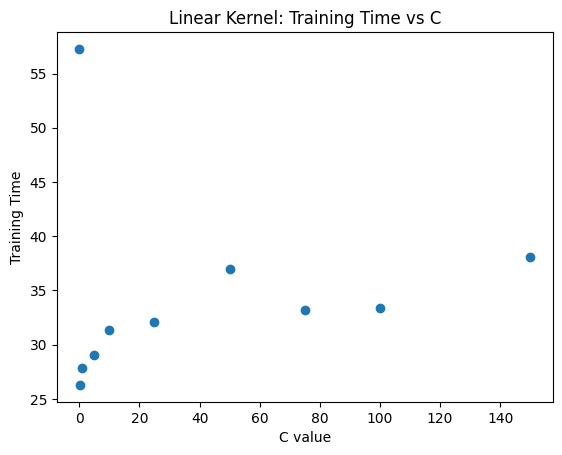

In [ ]:
# creating graphs for C in linear kernel
import time

C_values = [None, 0.001, 0.1 , 1.0, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0, 150.0]

metrics_results = []
for C_value in C_values:
    svc = Support_Vector_Machines_cvxopt(kernel = linear_kernel, C = C_value)
    start_time = time.time()
    svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = svc.predict(X_test_binary_features_subset)
    metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)
    metrics["Training Time"] = training_time
    metrics_results.append(metrics)

metrics_plotting(metrics_results,C_values,type_of_kernel = "Linear",hyperparameter = "C")

**Sigma Value of RBF Kernel**

Gram matrix elapsed time: 55.682963132858276s

QP solver elapsed time: 2.703080415725708s

Testing elapsed time: 58.90371251106262s

	Accuracy: 0.0
	Precision Weighted: 0.0
	Recall Weighted: 0.0
	F1-Score Weighted: 0.0
Gram matrix elapsed time: 55.695828676223755s

QP solver elapsed time: 2.6422250270843506s

Testing elapsed time: 59.48777675628662s

	Accuracy: 0.026
	Precision Weighted: 0.6729166666666667
	Recall Weighted: 0.026
	F1-Score Weighted: 0.049968502186318826
Gram matrix elapsed time: 51.85461211204529s

QP solver elapsed time: 2.7383742332458496s

Testing elapsed time: 57.00931119918823s

	Accuracy: 0.5145
	Precision Weighted: 0.5680013694068873
	Recall Weighted: 0.5145
	F1-Score Weighted: 0.3956239062800029
Gram matrix elapsed time: 52.832895040512085s

QP solver elapsed time: 6.005863189697266s

Testing elapsed time: 52.7919340133667s

	Accuracy: 0.6445
	Precision Weighted: 0.6445013005117046
	Recall Weighted: 0.6445
	F1-Score Weighted: 0.6444992001232004
Gram matrix elap

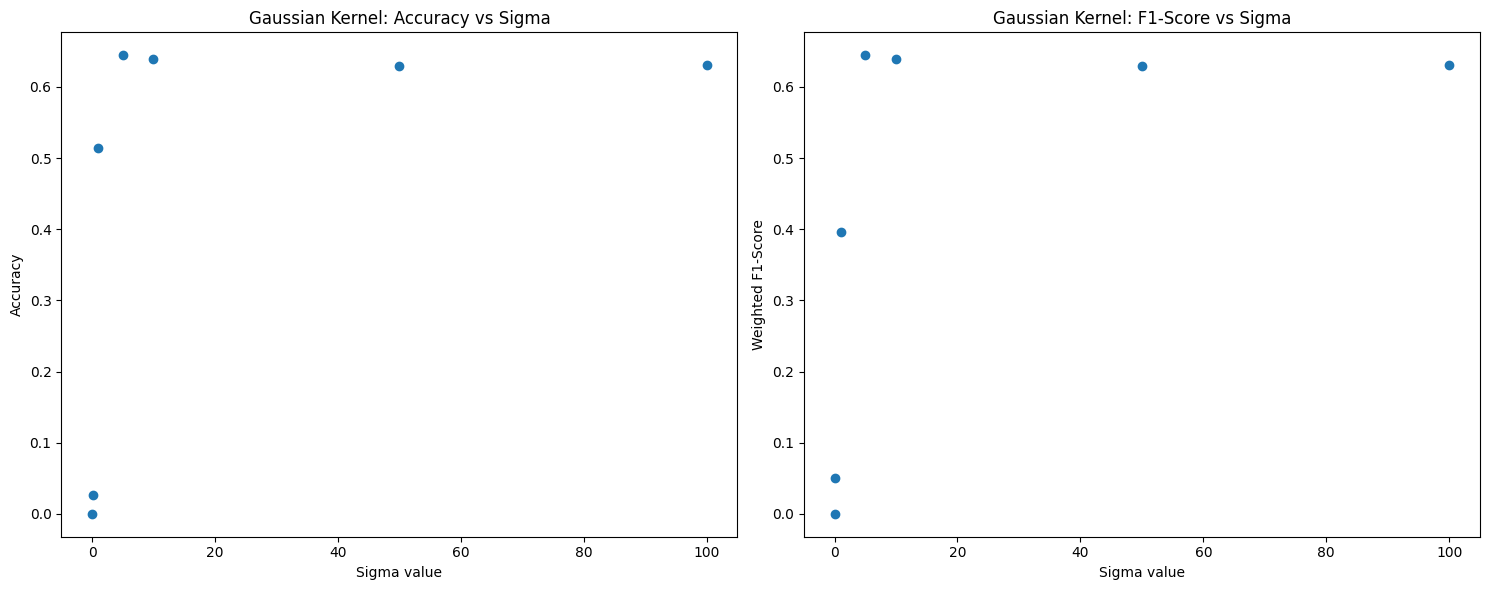

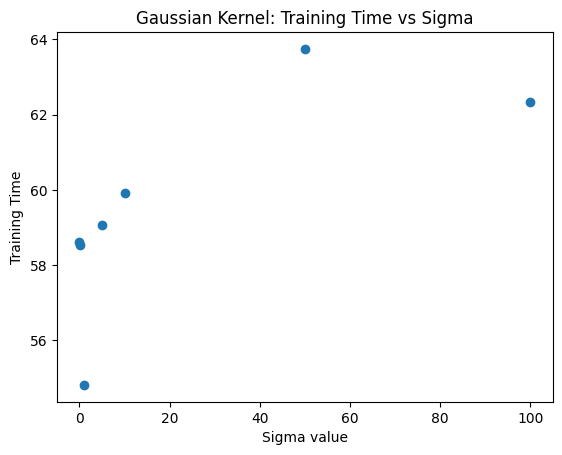

In [ ]:
# creating graphs for sigma in rbf kernel

sigma_values = [0.001, 0.1 , 1.0, 5.0, 10.0, 50.0, 100.0]
metrics_results = []

for sigma_value in sigma_values:
    svc = Support_Vector_Machines_cvxopt(kernel = gaussian_kernel, sigma = sigma_value)
    start_time = time.time()
    svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = svc.predict(X_test_binary_features_subset)
    metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)
    metrics["Training Time"] = training_time
    metrics_results.append(metrics)

metrics_plotting(metrics_results,sigma_values, type_of_kernel = "Gaussian",hyperparameter = "Sigma")

**Degree of Polynomial kernel (P)**

Gram matrix elapsed time: 30.934612035751343s

QP solver elapsed time: 4.310971021652222s

Testing elapsed time: 33.842474699020386s

	Accuracy: 0.5115
	Precision Weighted: 0.5115060867198749
	Recall Weighted: 0.5115
	F1-Score Weighted: 0.5114353873299743
Gram matrix elapsed time: 26.590864419937134s

QP solver elapsed time: 6.308107614517212s

Testing elapsed time: 23.87308406829834s

	Accuracy: 0.61
	Precision Weighted: 0.6100017600281605
	Recall Weighted: 0.61
	F1-Score Weighted: 0.60999843999376
Gram matrix elapsed time: 26.31791043281555s

QP solver elapsed time: 6.881802797317505s

Testing elapsed time: 25.80994987487793s

	Accuracy: 0.59
	Precision Weighted: 0.5906705997557937
	Recall Weighted: 0.59
	F1-Score Weighted: 0.5892405056950302
Gram matrix elapsed time: 26.77831268310547s

QP solver elapsed time: 6.07435941696167s

Testing elapsed time: 24.2188880443573s

	Accuracy: 0.56
	Precision Weighted: 0.5651836658424554
	Recall Weighted: 0.56
	F1-Score Weighted: 0.55107492049434

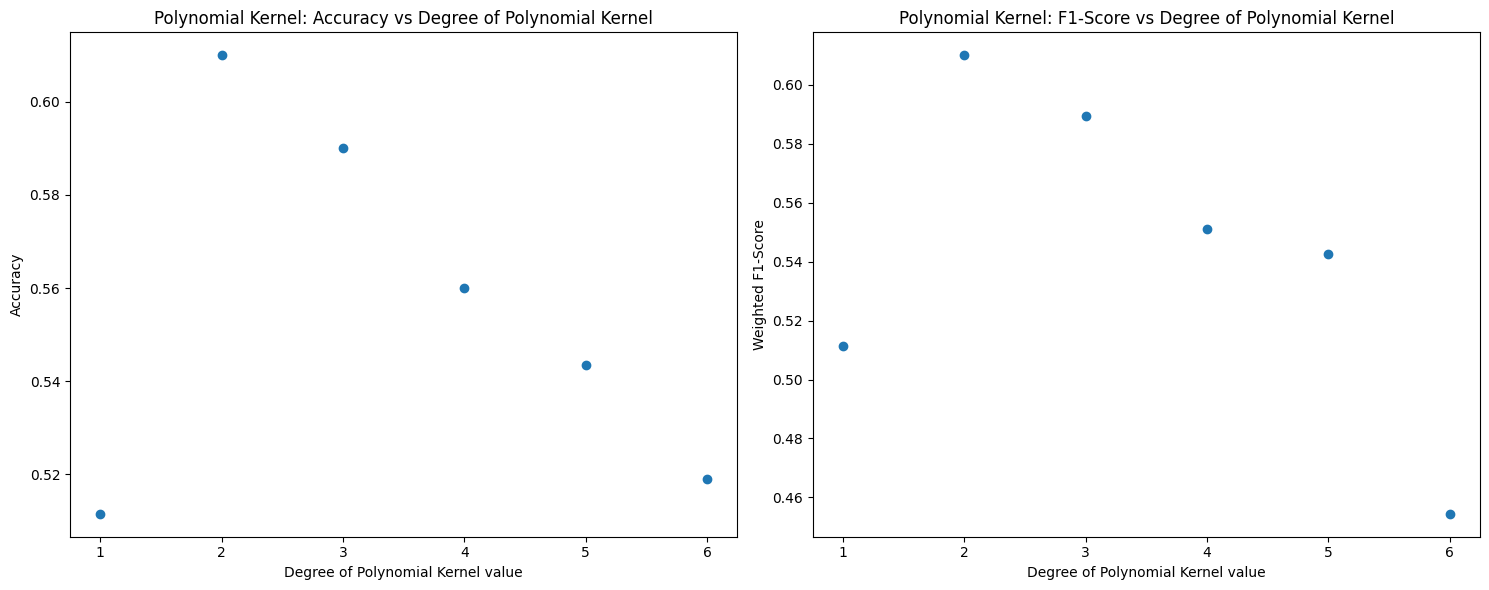

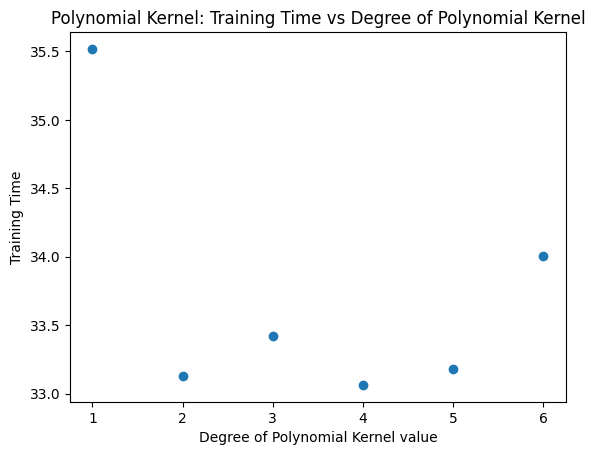

In [ ]:
# creating graphs for p in polynomial kernel
p_values = [1, 2, 3, 4, 5, 6]
metrics_results = []

for p_value in p_values:
    svc = Support_Vector_Machines_cvxopt(kernel = polynomial_kernel, p = p_value)
    start_time = time.time()
    svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = svc.predict(X_test_binary_features_subset)
    metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)
    metrics["Training Time"] = training_time
    metrics_results.append(metrics)

metrics_plotting(metrics_results,p_values, type_of_kernel = "Polynomial",hyperparameter = "Degree of Polynomial Kernel")

**Retraining some of the best models of the cvxopt implementation**

In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = gaussian_kernel, sigma = 5.0,C=0.01)
start_time = time.time()
svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)
end_time = time.time()
training_time = end_time - start_time
y_pred = svc.predict(X_test_binary_features_subset)
metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)

Gram matrix elapsed time: 52.66430187225342s

QP solver elapsed time: 8.409018993377686s

Testing elapsed time: 57.5459566116333s

	Accuracy: 0.594
	Precision Weighted: 0.5941219820887871
	Recall Weighted: 0.594
	F1-Score Weighted: 0.5938684133659305


In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = polynomial_kernel, p=2 ,C=0.01)
start_time = time.time()
svc.fit(X_train_binary_features_subset,y_train_binary_features_subset)
end_time = time.time()
training_time = end_time - start_time
y_pred = svc.predict(X_test_binary_features_subset)
metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)

Gram matrix elapsed time: 43.5656795501709s

QP solver elapsed time: 18.789607524871826s

Testing elapsed time: 23.083218812942505s

	Accuracy: 0.615
	Precision Weighted: 0.6150225444187061
	Recall Weighted: 0.615
	F1-Score Weighted: 0.6149811340755698


In [ ]:
svc = Support_Vector_Machines_cvxopt(kernel = linear_kernel, C=1.0, sigma=1.0)
svc.fit(X_train_binary_features,y_train_binary_features)
# Evaluate on test set
y_pred = svc.predict(X_test_binary_features)

print('Test set accuracy: ', accuracy_score(y_test_binary_features,y_pred))
print(classification_report(y_test_binary_features, y_pred))

Gram matrix elapsed time: 303.0081558227539s

QP solver elapsed time: 1421.9621877670288s

Testing elapsed time: 52.723310232162476s

Test set accuracy:  0.67
              precision    recall  f1-score   support

          -1       0.67      0.66      0.67      1000
           1       0.67      0.68      0.67      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



**NUMPY ONLY IMPLEMENTATION**

In the following cells an alternative implementation from scratch is created, one where we use only numpy.

In [ ]:
class Support_Vector_Machines_numpy:

    def __init__(self, learning_rate = 0.001, kernel = "linear", gamma = None, C = 1.0, epochs = 1000):
      self.learning_rate = learning_rate # learning rate of the algorithm
      self.C = C # weight of the error term that is used to implement the Soft Margin SVM to reduce overfitting
      self.epochs = epochs # number of iterations during training
      self.gamma = gamma
      self.kernel = kernel # setting the type of kernel that will be used
      if kernel == "gaussian" and gamma == None: # setting gamma in case of false parameters given
        self.gamma = 1.0 # random initial variable given so that it does not break
      # algorithm parameters
      self.weights = None
      self.bias = None
      # the training data will be stored because they will be neeeded in the predict phase
      self.X_train = None
      # initialize empty lists that are going to store the learning curves
      self.loss_history_train = []
      self.loss_history_test = []
      self.accuracy_history_train = []
      self.accuracy_history_test = []

    def check_labels(self,y_train,y_test):
      # based on the implementation until now
      # the y_train and y_test should be 1-d arrays with labels 1 and -1
      # this function will be used to preprocess when needed

      # In the following lines I provide some lines in order to validate that
      # the input variables are in the correct format

      # Check if y_train is a 1D array with only 1 and -1 as values
      assert len(y_train.shape) == 1, "y_train is not a 1D array"
      assert set(y_train) == {-1, 1}, "y_train contains values other than -1 and 1"

      # Check if y_test is a 1D array with only 1 and -1 as values
      assert len(y_test.shape) == 1, "y_test is not a 1D array"
      assert set(y_test) == {-1, 1}, "y_test contains values other than -1 and 1"


    def hinge_loss(self, X, y):
      # The regularization term of the cost function 1/2 * ||w||
      regularizer = 0.5 * np.linalg.norm(self.weights)**2
      if self.kernel == "linear":
        # Addding the error term to enable that is used when wrong classification
        # are enabled
        errors = y * (np.dot(X, self.weights) + self.bias)
        hinge_loss = np.sum(np.maximum(0, 1 - errors))
      elif self.kernel == "gaussian":
        hinge_loss = 0
        for i in range(len(X)):
            prediction = self.bias
            for j in range(len(self.X_train)):
                prediction += self.weights[j] * y[j] * self.gaussian_kernel(X[i], self.X_train[j])
            condition = y[i] * prediction >= 1
            hinge_loss += max(0, 1 - y[i] * prediction)

      # Total Calculated Loss  (sum of hinge loss and regularization term)
      total_loss = regularizer + self.C * hinge_loss/len(y) # C shows the power of the hinge loss term

      return total_loss

    # Implementation of Radial Basis Function (RBF) Kernel / Gaussian Kernel
    def gaussian_kernel(self, x, y):
        return np.exp(-np.linalg.norm(x-y)**2 / (2 * (self.gamma ** 2)))

    # Function to plot the learning curves at the end of the learning process
    def plot_learning_curves(self):
        # Set a larger width for the plots
        figsize = (15, 6)

        # Create the figure with the specified figsize
        plt.figure(figsize=figsize)

        # Plotting loss
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history_train, label='Training Loss')
        plt.plot(self.loss_history_test, label='Test Loss')
        plt.title('Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_history_train, label='Training Accuracy')
        plt.plot(self.accuracy_history_test, label='Test Accuracy')
        plt.title('Accuracy Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    '''
    X should not be in an images format.
    y should be label encoded with y = 1 or  y = -1
    '''
    def fit(self, X_train, y_train, X_test, y_test, plot = 1):
      # Note that the test data do not affect the training procedure.
      # They are just used to calculate loss and accuracy in the test set throughout training
      n_samples, n_features = X_train.shape # get the number of samples and number of features

      self.X_train = X_train.copy() # to avoid modifying the original data

      # initialize weights and bias to zero
      if self.kernel == "linear":
        self.weights = np.zeros(n_features)
      elif self.kernel == "gaussian":
        self.weights = np.zeros(n_samples)

      self.bias = 0
      # print("Weights: ", self.weights)
      # print("Bias: ", self.bias)
      for _ in range(self.epochs):
        # Performing data shuffling in the beginning of every epoch
        # This was found in many approaches in order to reduce the bias that is
        # introduced by the order in the training samples
        shuffle_index = np.random.permutation(n_samples)
        X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
        # print('X shape is: ', X_train.shape)
        # Running through the examples of the training dataset
        # Now this is implemented using Stochastic Gradient Descent
        if self.kernel == "linear":
            for idx, x_i in enumerate(X_train):
              # print('X_i shape: ', x_i.shape)
              # print('Weights shape: ',self.weights.shape)
              # print('Y_train[idx]', y_train[idx],' with shape: ', y_train[idx].shape)
              # Condition to check if the current example is missclassified
              condition = y_train[idx] * (np.dot(x_i , self.weights) + self.bias) >=1
              # print("Dot product: ", np.dot(x_i,self.weights))
              # print('Weights before Update:', self.weights)
              # print('Bias before Update:', self.bias)
              if condition: # examples classified correctly
                # print('Condition 1')
                self.weights = self.weights - self.learning_rate * self.weights
                # the bias term is not present in the regulizers (0.5* ||w||^2)
              else: # missclassified examples
                # print('Condition 2')
                self.weights = self.weights - self.learning_rate * self.weights + self.learning_rate * self.C * y_train[idx] * x_i
                self.bias = self.bias + self.learning_rate * self.C * y_train[idx]
                # print('Weights after Update:', self.weights)
                # print('Bias after Update:', self.bias)
        elif self.kernel == "gaussian":
            for idx, x_i in enumerate(X_train):
              kernel_values = [self.gaussian_kernel(x_i, x_j) for x_j in X_train]
              kernel_sum = np.dot(self.weights, kernel_values) + self.bias
              condition = y_train[idx] * kernel_sum >= 1

              if condition:
                  self.weights -= self.learning_rate * self.weights
              else:
                  # weighted_kernel_values = -y_train[idx] * np.array(kernel_values)
                  # self.weights -= self.learning_rate * (weighted_kernel_values + self.C * y_train[idx] * self.weights)
                  # self.bias += self.learning_rate * self.C * y_train[idx]
                  weighted_kernel_values = -y_train[idx] * np.array(kernel_values)
                  self.weights -= self.learning_rate * (self.weights - self.C * y_train[idx] * weighted_kernel_values)
                  self.bias += self.learning_rate * self.C * y_train[idx]

        train_loss = self.hinge_loss(X_train,y_train) # calculate the current training loss
        test_loss = self.hinge_loss(X_test,y_test) # calculate the current test loss

        self.loss_history_test.append(test_loss) # store the test loss in the history
        self.loss_history_train.append(train_loss) # store the training loss in the history

        train_predictions = self.predict(X_train) # calculate the current training predictions
        test_predictions = self.predict(X_test) # calculate the current testing predictions

        accuracy_train = np.mean(train_predictions == y_train) # measure accuracy in training set
        accuracy_test = np.mean(test_predictions == y_test) # measure accuracy in test set

        self.accuracy_history_train.append(accuracy_train) # store the training accuracy in the history
        self.accuracy_history_test.append(accuracy_test) # store the test accuracy in the history

      if plot: # if we want to take the plots
        self.plot_learning_curves()

      return self.weights,self.bias,self.loss_history_train

    def predict(self, X_test):
      if self.kernel == "linear":
        # Use the Linear kernel for prediction
        prediction = np.dot(X_test, self.weights) + self.bias
        prediction = np.sign(prediction)
      elif self.kernel == "gaussian":
        # Use the Gaussian kernel for prediction
        predictions = []
        for x_i in X_test:
            kernel_sum = np.sum([self.gaussian_kernel(x_i, x_j) * weight for x_j, weight in zip(self.X_train, self.weights)])
            prediction = kernel_sum + self.bias
            predictions.append(prediction)
        prediction = np.array(predictions)
        prediction = np.sign(prediction)
      else:
        # Possible enhancement to develop the polynomial kernels as well
        raise ValueError("The kernel specified has not been implemented!")

      return prediction.astype(int)

**Testing the Numpy Implementation on the Synthetic Dataset**

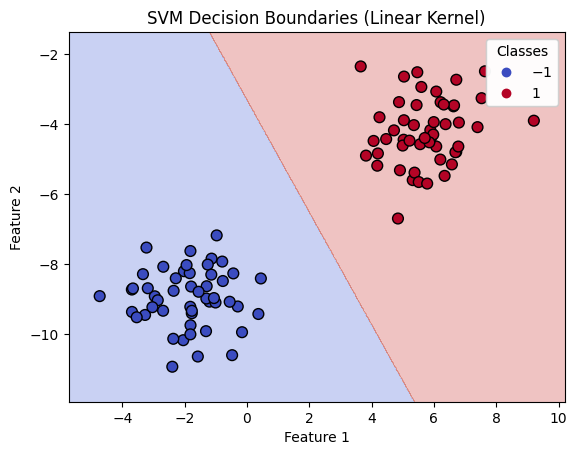

Test set accuracy:  1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        29

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear")
svm.fit(X_train_base, y_train_base, X_test_base, y_test_base)

y_pred = svm.predict(X_test_base)

plot_decision_boundary(X_base, y_base, svm, "SVM Decision Boundaries (Linear Kernel)")

print('Test set accuracy: ', accuracy_score(y_test_base,y_pred))
print(classification_report(y_test_base, y_pred))

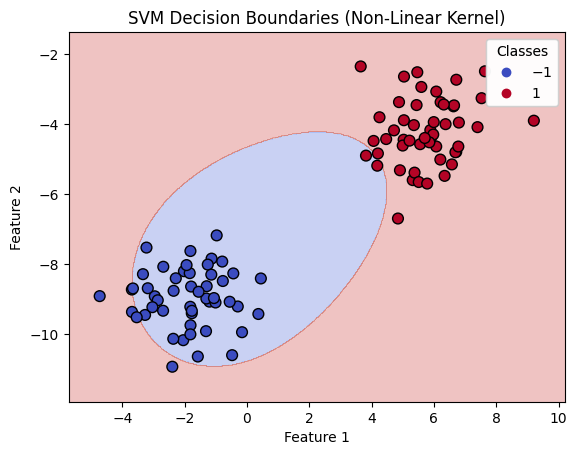

Test set accuracy:  0.98
              precision    recall  f1-score   support

          -1       1.00      0.95      0.98        21
           1       0.97      1.00      0.98        29

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [ ]:
svm = Support_Vector_Machines_numpy(kernel="gaussian", gamma=5.0, C=5.0)
svm.fit(X_train_base, y_train_base, X_test_base, y_test_base)

y_pred = svm.predict(X_test_base)

plot_decision_boundary(X_base, y_base, svm, "SVM Decision Boundaries (Non-Linear Kernel)")

print('Test set accuracy: ', accuracy_score(y_test_base,y_pred))
print(classification_report(y_test_base, y_pred))

Examining the new hyperparameter that was added in this implementation -> The Learning Rate

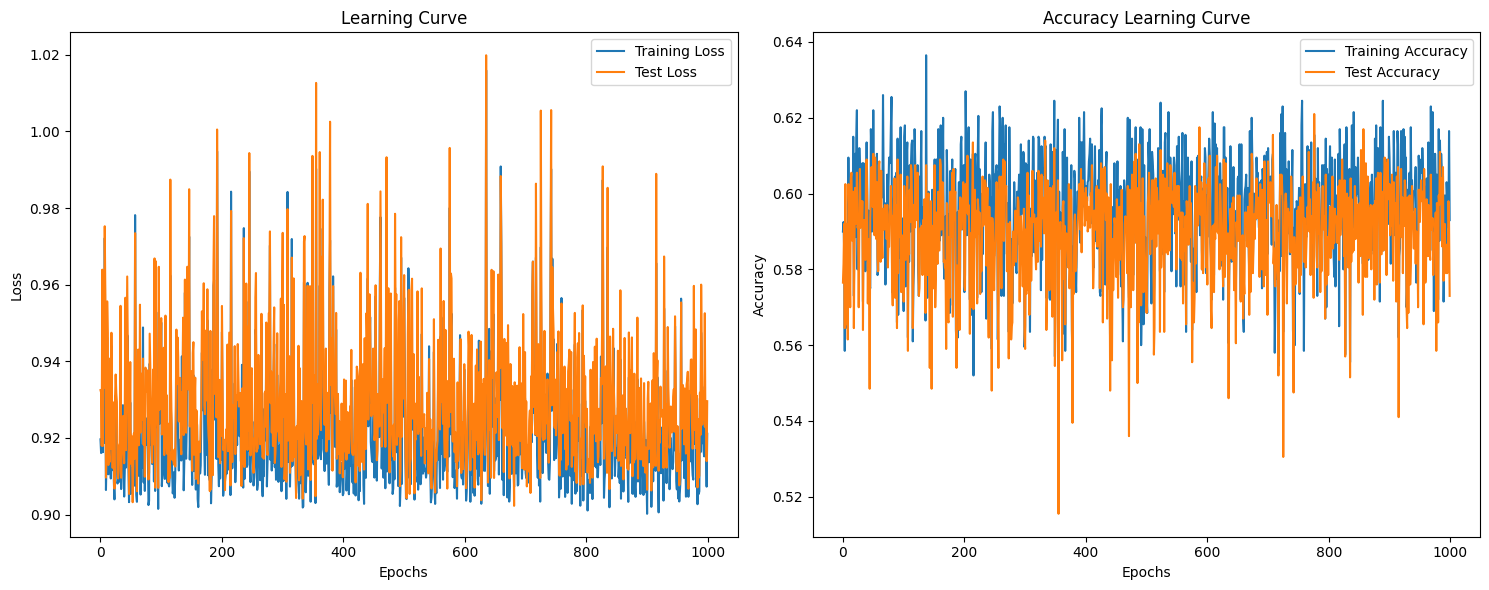

Test set accuracy:  0.573
              precision    recall  f1-score   support

          -1       0.59      0.47      0.53      1000
           1       0.56      0.67      0.61      1000

    accuracy                           0.57      2000
   macro avg       0.58      0.57      0.57      2000
weighted avg       0.58      0.57      0.57      2000



In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear")
svm.fit(X_train_binary_subset, y_train_binary_subset, X_test_binary_subset, y_test_binary_subset)

y_pred = svm.predict(X_test_binary_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_subset,y_pred))
print(classification_report(y_test_binary_subset, y_pred))

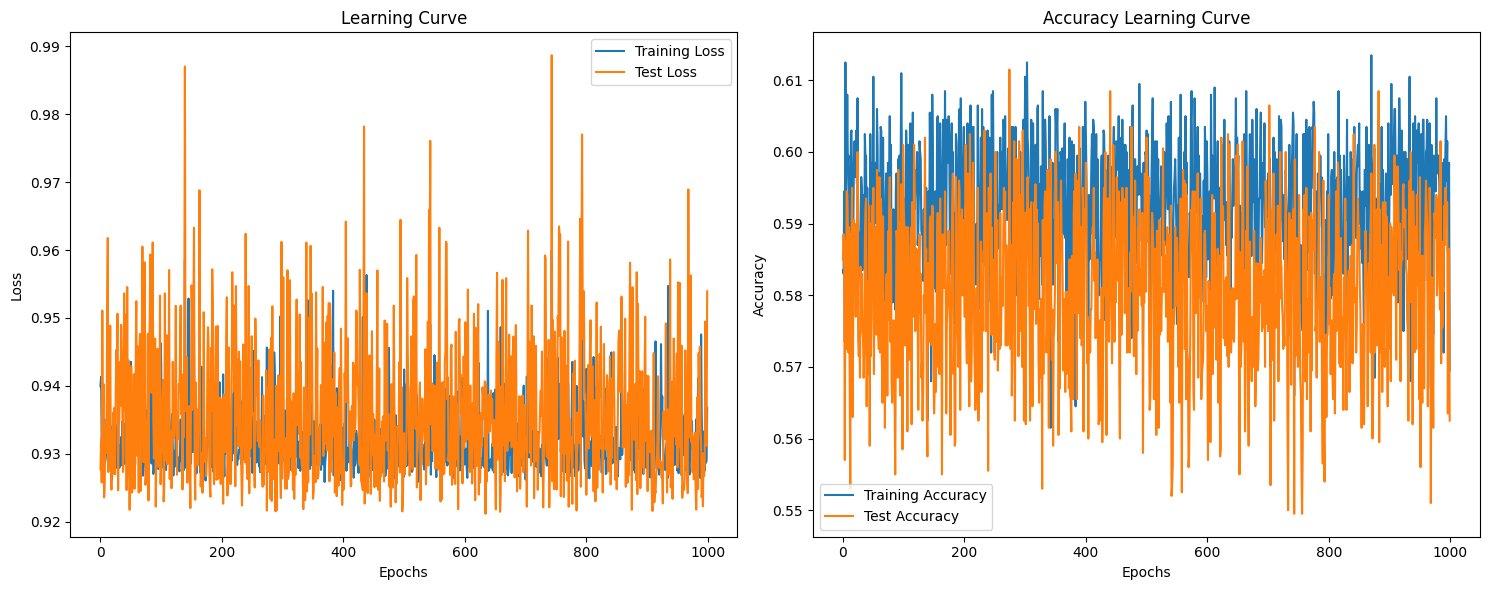

Test set accuracy:  0.5625
              precision    recall  f1-score   support

          -1       0.56      0.55      0.56      1000
           1       0.56      0.58      0.57      1000

    accuracy                           0.56      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.56      0.56      0.56      2000



In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear")
svm.fit(X_train_binary_features_subset, y_train_binary_features_subset, X_test_binary_features_subset, y_test_binary_features_subset)

y_pred = svm.predict(X_test_binary_features_subset)


print('Test set accuracy: ', accuracy_score(y_test_binary_features_subset,y_pred))
print(classification_report(y_test_binary_features_subset, y_pred))

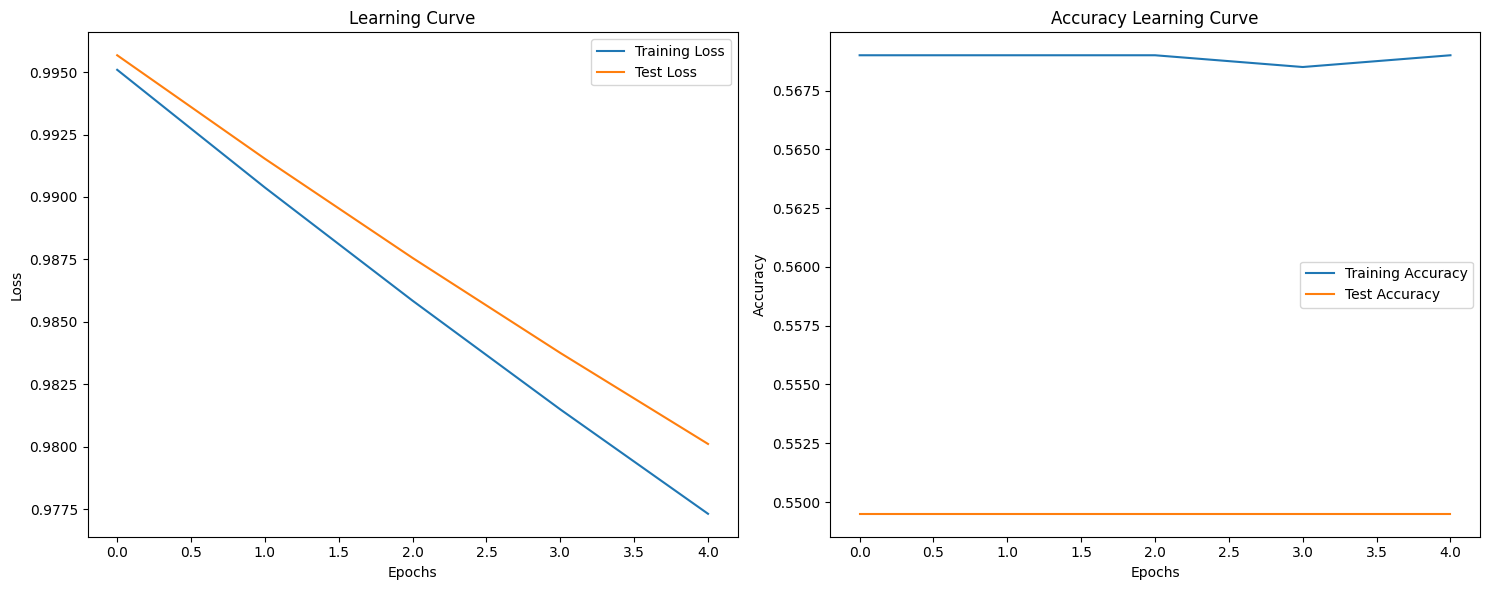

Test set accuracy:  0.5495
              precision    recall  f1-score   support

          -1       0.54      0.69      0.61      1000
           1       0.57      0.41      0.47      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.54      2000
weighted avg       0.55      0.55      0.54      2000



In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear", learning_rate = 1e-5,epochs = 5)
svm.fit(X_train_binary_features_subset, y_train_binary_features_subset, X_test_binary_features_subset, y_test_binary_features_subset)

y_pred = svm.predict(X_test_binary_features_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_features_subset,y_pred))
print(classification_report(y_test_binary_features_subset, y_pred))

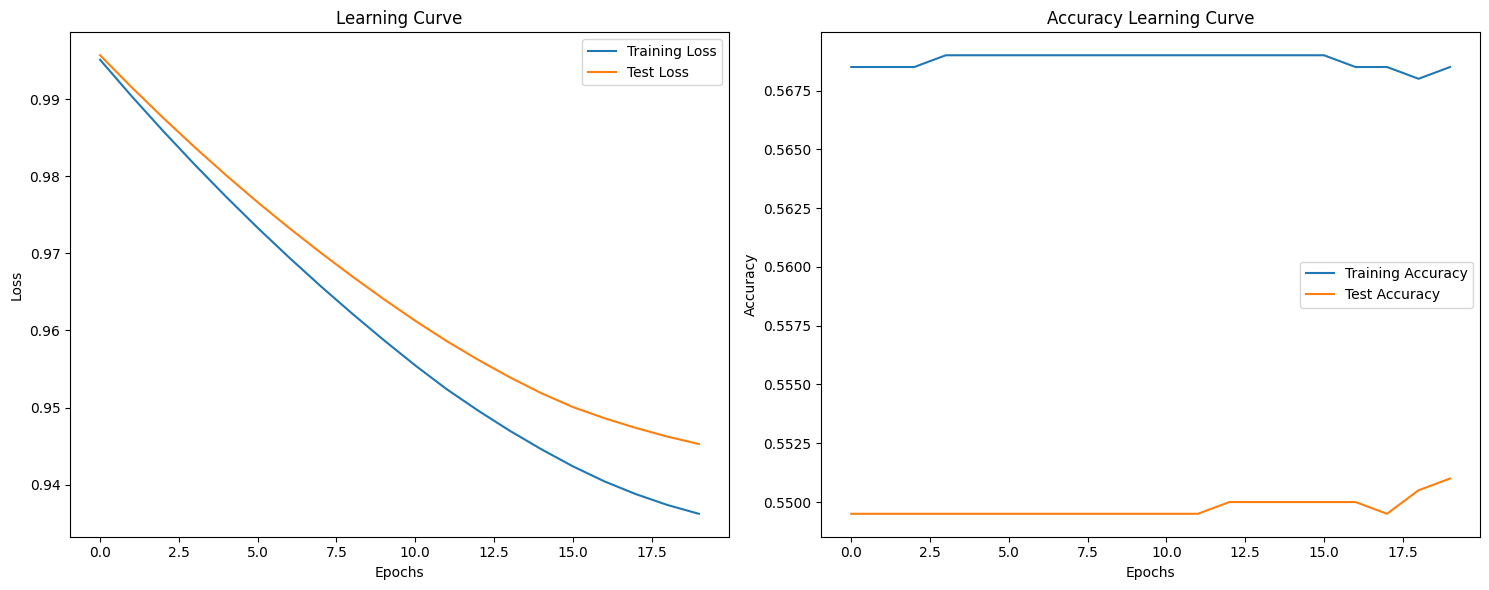

Test set accuracy:  0.551
              precision    recall  f1-score   support

          -1       0.54      0.69      0.61      1000
           1       0.57      0.41      0.48      1000

    accuracy                           0.55      2000
   macro avg       0.56      0.55      0.54      2000
weighted avg       0.56      0.55      0.54      2000



In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear", learning_rate = 1e-5,epochs = 20)
svm.fit(X_train_binary_features_subset, y_train_binary_features_subset, X_test_binary_features_subset, y_test_binary_features_subset)

y_pred = svm.predict(X_test_binary_features_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_features_subset,y_pred))
print(classification_report(y_test_binary_features_subset, y_pred))

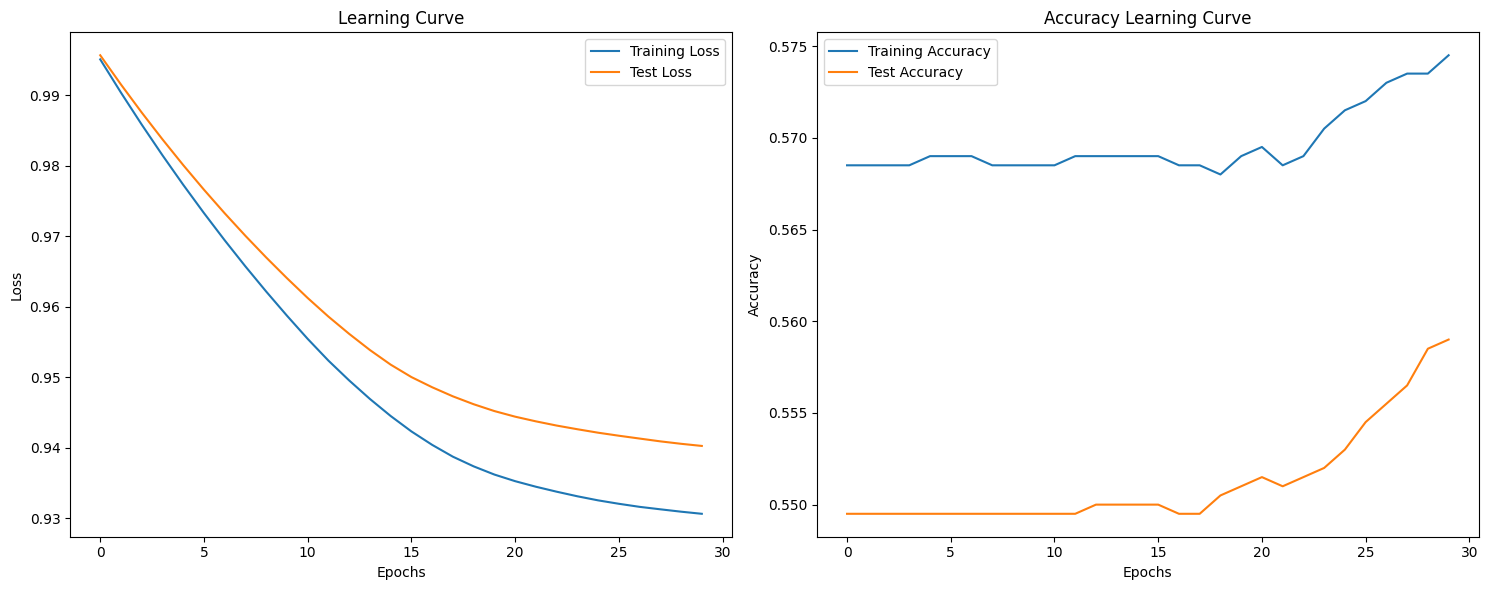

Test set accuracy:  0.559
              precision    recall  f1-score   support

          -1       0.55      0.70      0.61      1000
           1       0.58      0.42      0.49      1000

    accuracy                           0.56      2000
   macro avg       0.56      0.56      0.55      2000
weighted avg       0.56      0.56      0.55      2000



In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear", learning_rate = 1e-5,epochs = 30)
svm.fit(X_train_binary_features_subset, y_train_binary_features_subset, X_test_binary_features_subset, y_test_binary_features_subset)

y_pred = svm.predict(X_test_binary_features_subset)

print('Test set accuracy: ', accuracy_score(y_test_binary_features_subset,y_pred))
print(classification_report(y_test_binary_features_subset, y_pred))

**Hyperaparameters' Exploration**

	Accuracy: 0.0
	Precision Weighted: 0.0
	Recall Weighted: 0.0
	F1-Score Weighted: 0.0
	Accuracy: 0.5635
	Precision Weighted: 0.5686950642325896
	Recall Weighted: 0.5635
	F1-Score Weighted: 0.5550883898709985
	Accuracy: 0.559
	Precision Weighted: 0.5635655306752168
	Recall Weighted: 0.559
	F1-Score Weighted: 0.5509366179112137
	Accuracy: 0.57
	Precision Weighted: 0.5717922210051731
	Recall Weighted: 0.57
	F1-Score Weighted: 0.5672995162811104
	Accuracy: 0.581
	Precision Weighted: 0.5811051122254441
	Recall Weighted: 0.581
	F1-Score Weighted: 0.5808642000008002
	Accuracy: 0.5885
	Precision Weighted: 0.5885071690806956
	Recall Weighted: 0.5885
	F1-Score Weighted: 0.5884916669562558
	Accuracy: 0.57
	Precision Weighted: 0.5723439437784208
	Recall Weighted: 0.57
	F1-Score Weighted: 0.5664885573142453
	Accuracy: 0.5775
	Precision Weighted: 0.5788115022082475
	Recall Weighted: 0.5775
	F1-Score Weighted: 0.5757349513312758
	Accuracy: 0.5385
	Precision Weighted: 0.5417498500800839
	Recall Weight

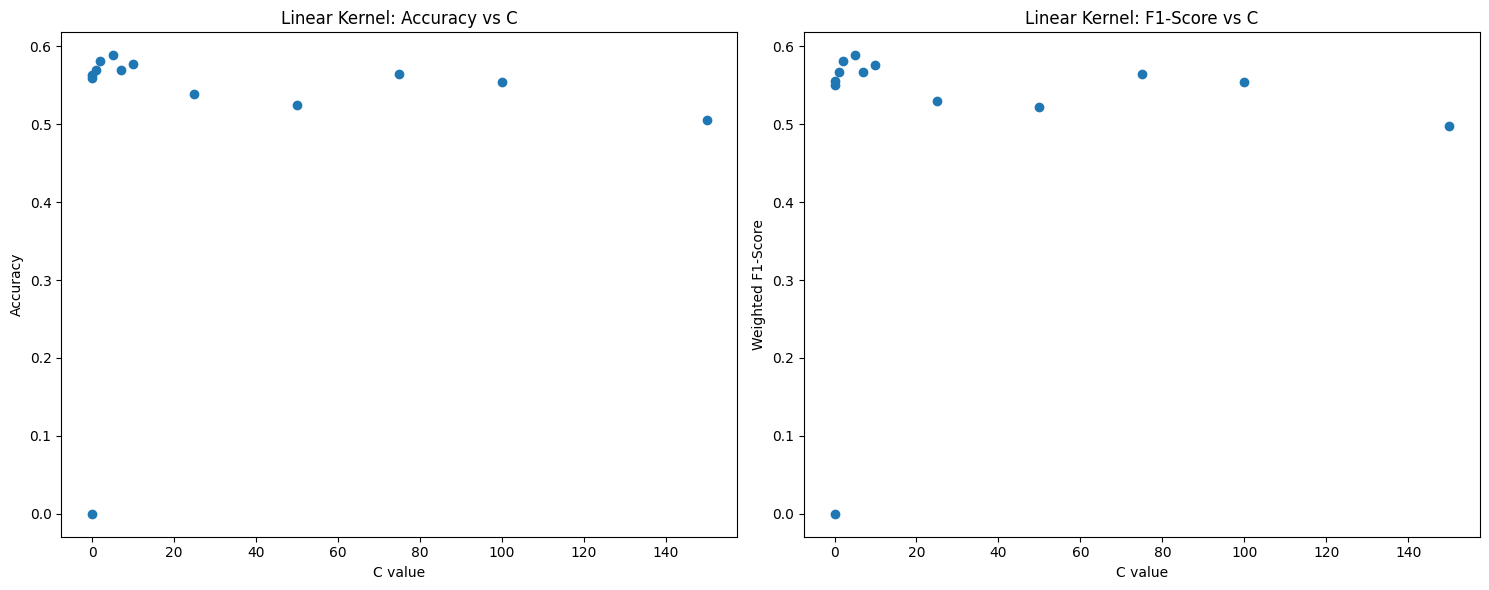

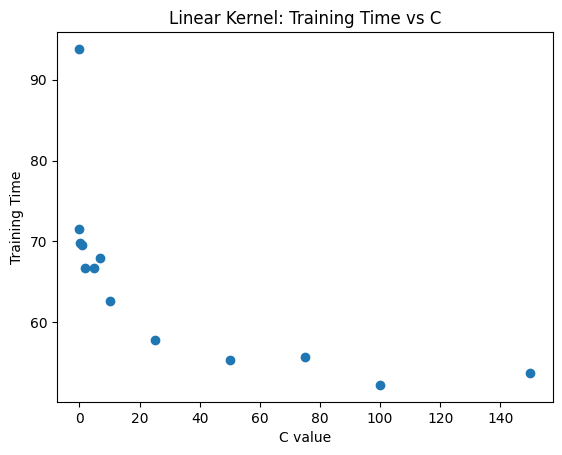

In [ ]:
# creating graphs for C in linear kernel
C_values = [0, 0.001, 0.1 , 1.0,2.0, 5.0, 7.0, 10.0,25.0, 50.0, 75.0, 100.0, 150.0]

metrics_results = []
for C_value in C_values:
    svm = Support_Vector_Machines_numpy(kernel="linear", C = C_value)
    start_time = time.time()
    svm.fit(X_train_binary_features_subset,y_train_binary_features_subset,X_test_binary_features_subset,y_test_binary_features_subset,plot=0)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = svm.predict(X_test_binary_features_subset)
    metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)
    metrics["Training Time"] = training_time
    metrics_results.append(metrics)

metrics_plotting(metrics_results,C_values,type_of_kernel = "Linear",hyperparameter = "C")

	Accuracy: 0.5895
	Precision Weighted: 0.5900062853551226
	Recall Weighted: 0.5895
	F1-Score Weighted: 0.5889219214520419
	Accuracy: 0.604
	Precision Weighted: 0.6049271361752444
	Recall Weighted: 0.604
	F1-Score Weighted: 0.6031232993683046
	Accuracy: 0.588
	Precision Weighted: 0.588538669263801
	Recall Weighted: 0.588
	F1-Score Weighted: 0.5873723934103772
	Accuracy: 0.5675
	Precision Weighted: 0.5679912366850495
	Recall Weighted: 0.5675
	F1-Score Weighted: 0.5667173832735377
	Accuracy: 0.5695
	Precision Weighted: 0.569742774598377
	Recall Weighted: 0.5695
	F1-Score Weighted: 0.5691250310582784
	Accuracy: 0.554
	Precision Weighted: 0.5543137160237531
	Recall Weighted: 0.554
	F1-Score Weighted: 0.5533550446845243
	Accuracy: 0.5875
	Precision Weighted: 0.5883660759099939
	Recall Weighted: 0.5875
	F1-Score Weighted: 0.586486789255373
	Accuracy: 0.583
	Precision Weighted: 0.5849629848008386
	Recall Weighted: 0.583
	F1-Score Weighted: 0.5805774151499058
	Accuracy: 0.574
	Precision Weighte

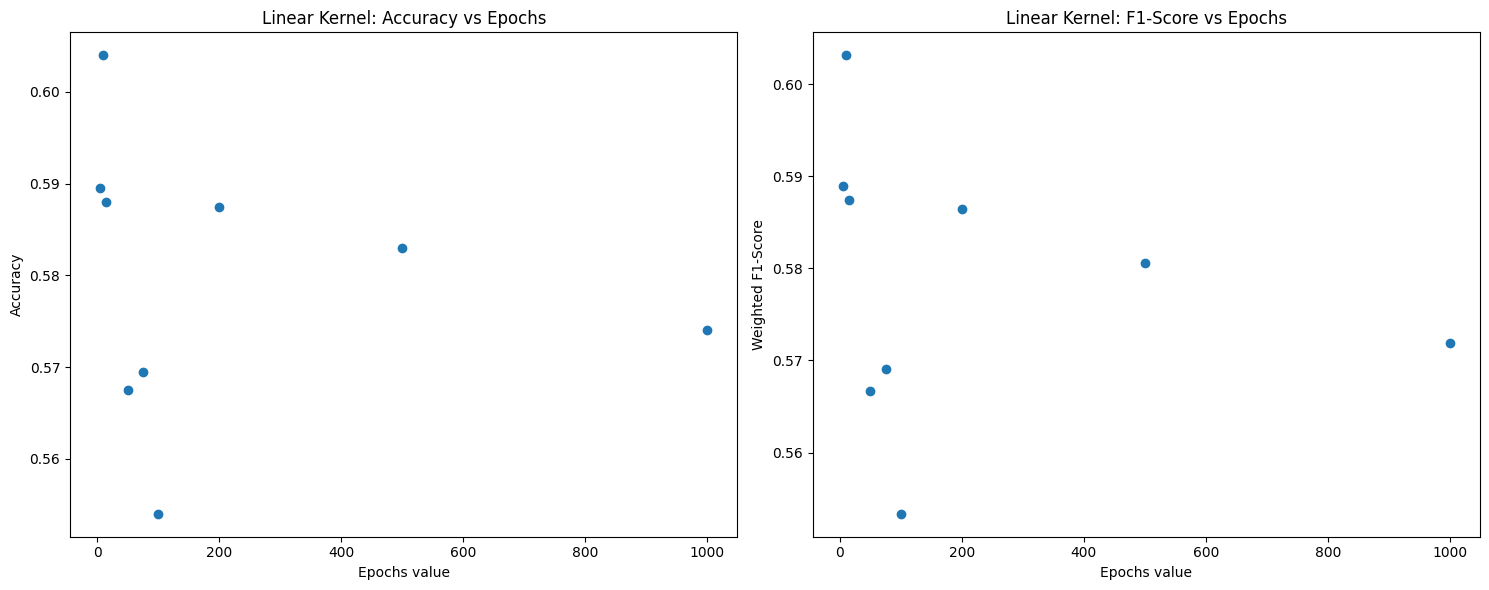

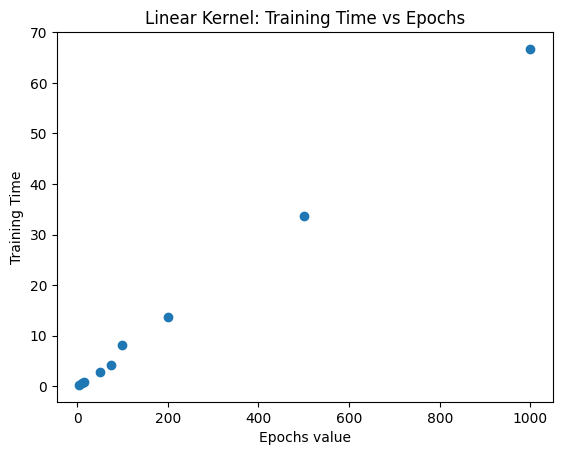

In [ ]:
# creating graphs for C in linear kernel
epochs_values = [5,10,15,50,75,100,200,500,1000]

metrics_results = []
for epoch_value in epochs_values:
    svm = Support_Vector_Machines_numpy(kernel="linear",epochs = epoch_value)
    start_time = time.time()
    svm.fit(X_train_binary_features_subset,y_train_binary_features_subset,X_test_binary_features_subset,y_test_binary_features_subset,plot=0)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = svm.predict(X_test_binary_features_subset)
    metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)
    metrics["Training Time"] = training_time
    metrics_results.append(metrics)

metrics_plotting(metrics_results,epochs_values,type_of_kernel = "Linear",hyperparameter = "Epochs")

	Accuracy: 0.5765
	Precision Weighted: 0.5765643906525388
	Recall Weighted: 0.5765
	F1-Score Weighted: 0.576410940400219
	Accuracy: 0.5755
	Precision Weighted: 0.5755091366055292
	Recall Weighted: 0.5755
	F1-Score Weighted: 0.5754871584865443
	Accuracy: 0.5955
	Precision Weighted: 0.597015873015873
	Recall Weighted: 0.5955
	F1-Score Weighted: 0.5939137254901962
	Accuracy: 0.5405
	Precision Weighted: 0.5406320134115742
	Recall Weighted: 0.5405
	F1-Score Weighted: 0.5401264677234083
	Accuracy: 0.49
	Precision Weighted: 0.4898115545122587
	Recall Weighted: 0.49
	F1-Score Weighted: 0.4876308048415875
	Accuracy: 0.4625
	Precision Weighted: 0.4624022081433809
	Recall Weighted: 0.4625
	F1-Score Weighted: 0.46215026320865144
	Accuracy: 0.5275
	Precision Weighted: 0.5275121328505871
	Recall Weighted: 0.5275
	F1-Score Weighted: 0.5274479011310997
	Accuracy: 0.487
	Precision Weighted: 0.4868578545548654
	Recall Weighted: 0.487
	F1-Score Weighted: 0.48560908697117017


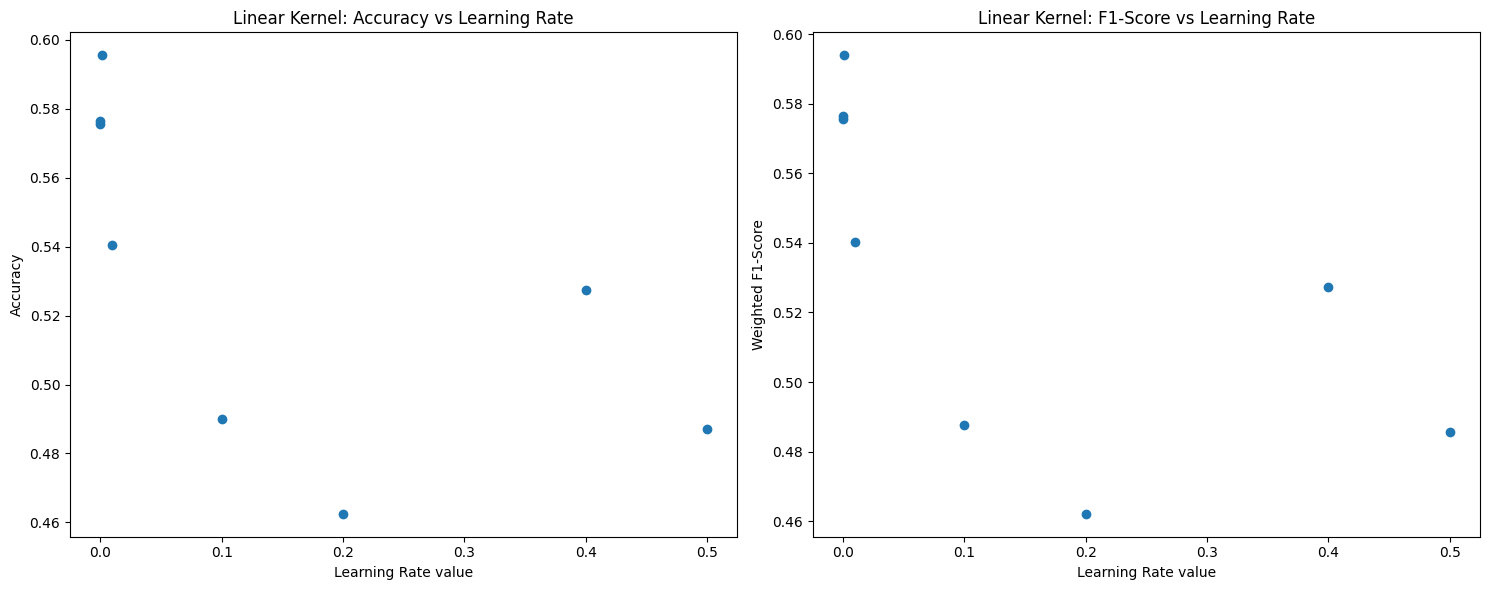

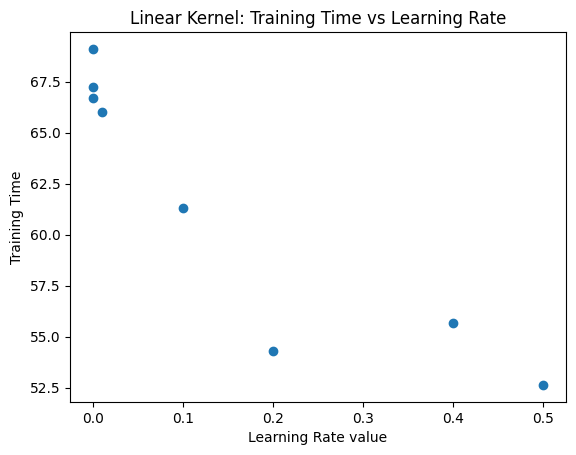

In [ ]:
learning_rate_values = [0.00001,0.0001,0.001,0.01, 0.1, 0.2, 0.4, 0.5]

metrics_results = []
for learning_rate_value in learning_rate_values:
    svm = Support_Vector_Machines_numpy(kernel="linear",learning_rate = learning_rate_value)
    start_time = time.time()
    svm.fit(X_train_binary_features_subset,y_train_binary_features_subset,X_test_binary_features_subset,y_test_binary_features_subset,plot=0)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = svm.predict(X_test_binary_features_subset)
    metrics = evaluate_classification_metrics(y_test_binary_features_subset, y_pred)
    # adding the training time before appending it
    metrics["Training Time"] = training_time
    metrics_results.append(metrics)

metrics_plotting(metrics_results,learning_rate_values,type_of_kernel = "Linear",hyperparameter = "Learning Rate")

**Some of the best models of the numpy implementation**

In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear",learning_rate = 1e-4 ,epochs=60, C=2)
start_time = time.time()
svm.fit(X_train_binary_features,y_train_binary_features,X_test_binary_features,y_test_binary_features,plot=0)
end_time = time.time()
training_time = end_time - start_time
y_pred = svm.predict(X_test_binary_features)
metrics = evaluate_classification_metrics(y_test_binary_features, y_pred)
print('\tTraining Time:', training_time)

	Accuracy: 0.6015
	Precision Weighted: 0.6025460724854238
	Recall Weighted: 0.6015
	F1-Score Weighted: 0.6004811269941167
	Training Time: 19.712430715560913


In [ ]:
svm = Support_Vector_Machines_numpy(kernel="linear",learning_rate = 1e-4 ,epochs=60, C=2)
start_time = time.time()
svm.fit(X_train_binary, y_train_binary,X_test_binary,y_test_binary,plot=0)
end_time = time.time()
training_time = end_time - start_time
y_pred = svm.predict(X_test_binary)
metrics = evaluate_classification_metrics(y_test_binary_features, y_pred)
print('\tTraining Time:', training_time)

	Accuracy: 0.608
	Precision Weighted: 0.608084738434933
	Recall Weighted: 0.608
	F1-Score Weighted: 0.6079231529379758
	Training Time: 14.714821815490723


The non-linear kernels required a lot less data in order to successfully run in below 4 hours.

# Second Approach to SVM - SVM using frameworks

In the following cells, an approach to the creation of Support Vectors machines through utilizing libraries, such as scikit-learn, is implemented.

This approach was found to be imperative for this algorithm since the cost and time of training custom implementations can vary and increase exponentially taking many hours. However, it should be noted that according to the scikit-learn implementation the fit time scales at least quadratically with the number of samples and is impractical when the samples exceed 10 thousands.

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.2 MB/s eta 0:00:00


Classes for the creation of Linear and non-Linear Support Vector Classifiers with difffent parameters. Various hyperparameter exploration procedures are being exploited as well.

It is noted that this implementation supports Multi-Class Classification and thus not just binary classification problems can be tackled.

In [ ]:
# svm.svc handles the multiclass classification problem using one-vs-one scheme based on the latest update of scikit-learn -> is based on libsvm
'''
In order to further understand the implementation, some of the scikit-learn documentation is given in the comment to explain the parameters of the called function.
 The parameters of svm.SVC are:
 -   C: Regularization  Parameter - The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
 -   kernel:Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used.
     If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).
 -   gamma:Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
 -   degree: Degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.
 -   tol:Tolerance for stopping criterion.
 -   max_iter: Hard limit on iterations within solver, or -1 for no limit.
 -   class_weight: Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one.
     The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.
'''
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
import time

class SupportVectorMachineClassifier:
    def __init__(self, kernel='linear', C=1.0, degree=3, gamma='scale',tol=1e-3,cache_size=200):
        self.kernel = kernel
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.tol = tol
        self.cache_size = cache_size
        self.model = self.initialize_model()
        self.best_parameters = None


    # Function to initialize a SVM model based on the sklearn implementation of SVMs
    def initialize_model(self):
        return svm.SVC(kernel=self.kernel, C=self.C, degree=self.degree, gamma=self.gamma, tol=self.tol, cache_size = self.cache_size)

    # Function to fit the model to the training data
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    # Function to used the saved model for predictions
    def predict(self, X_test):
        return self.model.predict(X_test)

    # Function that is used to perform grid search
    def tune_hyperparameters_grid_search(self, X_train, y,_train, param_grid, cv=5):
        grid_search = GridSearchCV(self.model, param_grid, cv=cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        self.best_parameters = best_params
        print(f"Best Hyperparameters (Grid Search): {best_params}")

    # Function that is used to perform random search
    def tune_hyperparameters_random_search(self, X_train, y_train, param_distributions, n_iter=10, cv=5):
        random_search = RandomizedSearchCV(self.model, param_distributions, n_iter=n_iter, cv=cv, n_jobs=-1)
        random_search.fit(X_train, y_train)
        best_params = random_search.best_params_
        self.best_parameters = best_params
        print(f"Best Hyperparameters (Random Search): {best_params}")
        return random_search.cv_results_

    # Function that is used to perform bayesian optimization
    def tune_hyperparameters_bayesian_optimization(self, X_train, y_train, search_spaces, n_iter=10, cv=5):
        bayes_search = BayesSearchCV(self.model, search_spaces, n_iter=n_iter,verbose=2, cv=cv, n_jobs=-1)
        bayes_search.fit(X_train, y_train)
        best_params = bayes_search.best_params_
        self.best_parameters = best_params
        print(f"Best Hyperparameters (Bayesian Optimization): {best_params}")
        return bayes_search.cv_results_

    # Function that is used after a search of best hyperparameters to acquire the best model
    def retrain_with_best_params(self,X_train,y_train):
        # Create a new instance of the class and set the model parameters using best_parameters
        # If the hyperparameters cannot be found inside the best parameters then default parameters are assigned
        best_model = svm.SVC(
            kernel=self.best_parameters.get('kernel', 'linear'),
            C=self.best_parameters.get('C', 1.0),
            degree=self.best_parameters.get('degree', 3),
            gamma=self.best_parameters.get('gamma', 'scale'),
            tol=self.best_parameters.get('tol', 1e-3),
        )
        self.model = best_model
        self.fit(X_train,y_train)

    # Function to evaluate the best so far model on test data
    def evaluate_classification_metrics(self, X_test, y_test, verbose=True):
      y_pred = self.predict(X_test)
      metrics = evaluate_classification_metrics(y_test, y_pred, verbose=verbose)
      return metrics

Maybe chech for the binary classification problem with scikit learn

**Initialization of Simple SVM Classifier**

In [ ]:
# Create and train the SVM classifier
svm_classifier = SupportVectorMachineClassifier(kernel='linear', C=1.0)
# Using time module to get the training time of the algorithm
start_time = time.time()
svm_classifier.fit(X_train_features_subset, y_train_features_subset)
end_time = time.time()

print("Training time: ", end_time - start_time)
# Evaluate the classifier
print("------------- Evaluation Metrics-----------------")
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_features_subset, y_test_features_subset)

Training time:  3.1887807846069336
------------- Evaluation Metrics-----------------
	Accuracy: 0.42433333333333334
	Precision Weighted: 0.4334077146040319
	Recall Weighted: 0.42433333333333334
	F1-Score Weighted: 0.42630723637439805


**Grid Search On Specific Parameters + Graphs**

The following script was created in order to check the influence of individual hyperparameters in the model's performance and training time.

Note that it is not used to create the optimal model as in the presented graphs only one parameter is changed every time and all the other have the default value.

In [ ]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import time


def plot_hyperparameter_results(hyperparameter_values, accuracy_results, f1_results, time_results, param_name):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Generate a set of distinct colors for each point
    colors = plt.cm.jet(np.linspace(0, 1, len(hyperparameter_values)))

    # Accuracy Plot
    axes[0].scatter(hyperparameter_values, accuracy_results, label='Accuracy', c=colors, marker='o')
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy vs. ' + param_name)

    # F1 Score Plot
    axes[1].scatter(hyperparameter_values, f1_results, label='F1 Score', c=colors, marker='o')
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('F1 Score vs. ' + param_name)

    # Training Time Plot
    axes[2].scatter(hyperparameter_values, time_results, label='Training Time', c=colors, marker='o')
    axes[2].set_xlabel(param_name)
    axes[2].set_ylabel('Training Time (seconds)')
    axes[2].set_title('Training Time vs. ' + param_name)

    plt.tight_layout()
    plt.show()


def hyperparameter_variation_analysis(X_train, y_train, X_val, y_val, hyperparameters):

    hyperparameters_accuracy_results = {}
    hyperparameters_f1_results = {}
    hyperparameters_time_results =  {}

    for param, values in hyperparameters.items():
        accuracy_list = []
        f1_list = []
        training_time_list = []
        if not isinstance(values, (list, tuple)):
          values = [values]
        for val in values:
          # Create a copy of hyperparameters with only one value changed
          current_hyperparameters = {}
          current_hyperparameters[param] = val
          if param == "degree":
            current_hyperparameters["kernel"] = 'poly'

          # Create a new instance of the model with the specified hyperparameters
          model = SupportVectorMachineClassifier(**current_hyperparameters)

          # Measuring the training time
          start_time = time.time()
          # Train the model
          model.fit(X_train, y_train)
          end_time = time.time()
          training_time = end_time - start_time

          # Evaluate the model on validation data
          metrics = model.evaluate_classification_metrics(X_val, y_val, verbose=False)

          accuracy_list.append(metrics['Accuracy'])
          f1_list.append(metrics['Weighted F1 Score'])
          training_time_list.append(training_time)

        hyperparameters_accuracy_results[param] = accuracy_list
        hyperparameters_f1_results[param] = f1_list
        hyperparameters_time_results[param] = training_time_list
        plot_hyperparameter_results(values, accuracy_list, f1_list, training_time_list, param)

**Exploration of individual hyperparameters on 2d images**

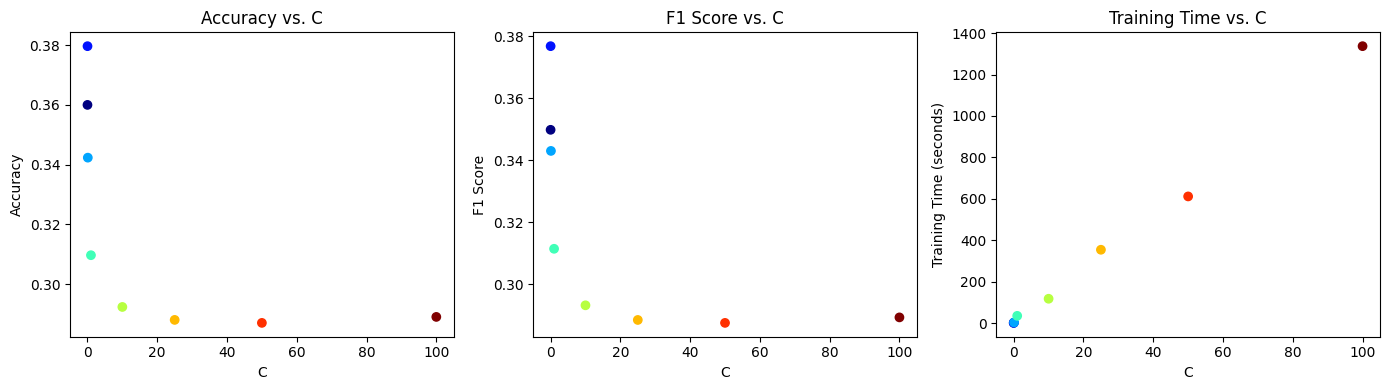

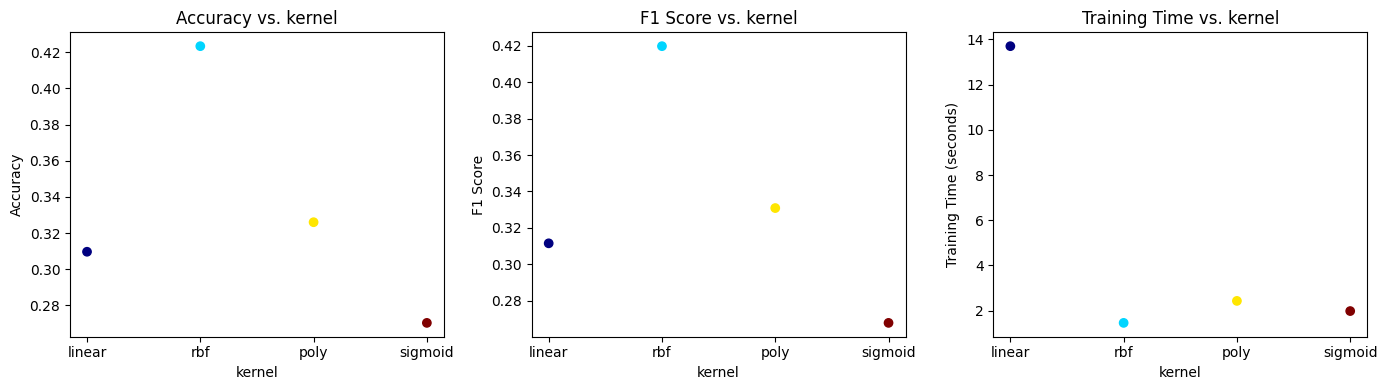

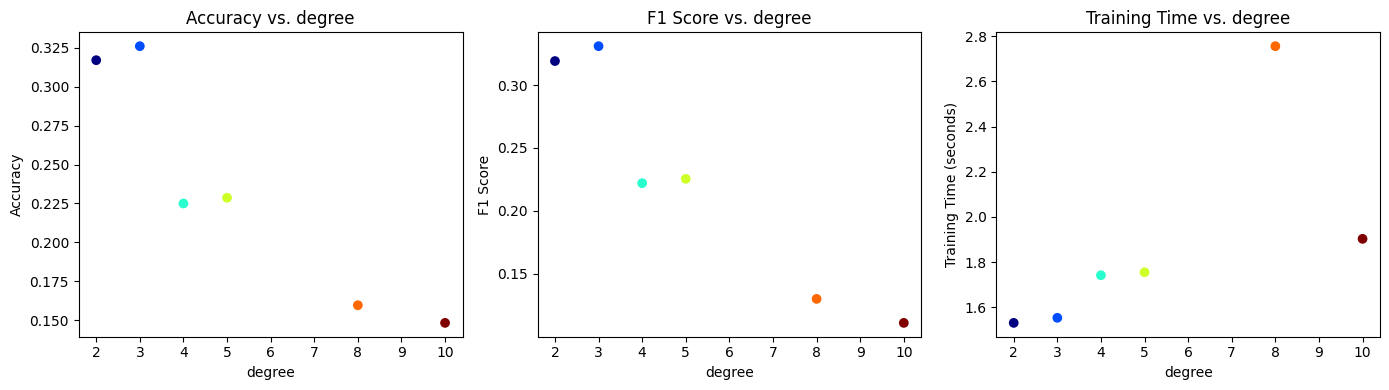

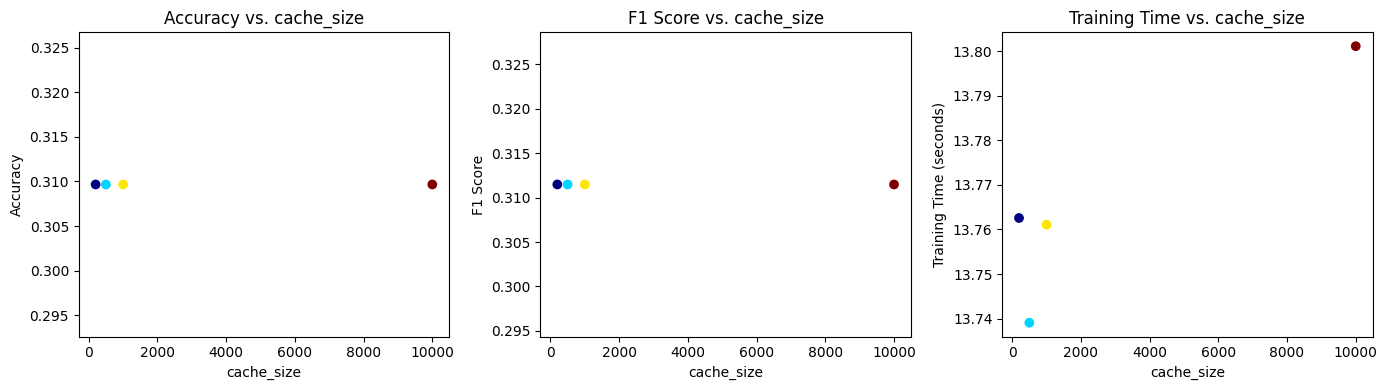

In [ ]:
hyperparameters = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 25.0, 50.0, 100.0],
                   'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                   'degree': [2, 3, 4, 5, 8, 10],
                   'cache_size':[200, 500, 1000, 10000]}

hyperparameter_variation_analysis(X_train_2d_subset, y_train_2d_subset, X_test_2d_subset, y_test_2d_subset, hyperparameters)

**Exploration of individual hyperparameters on extracted features**

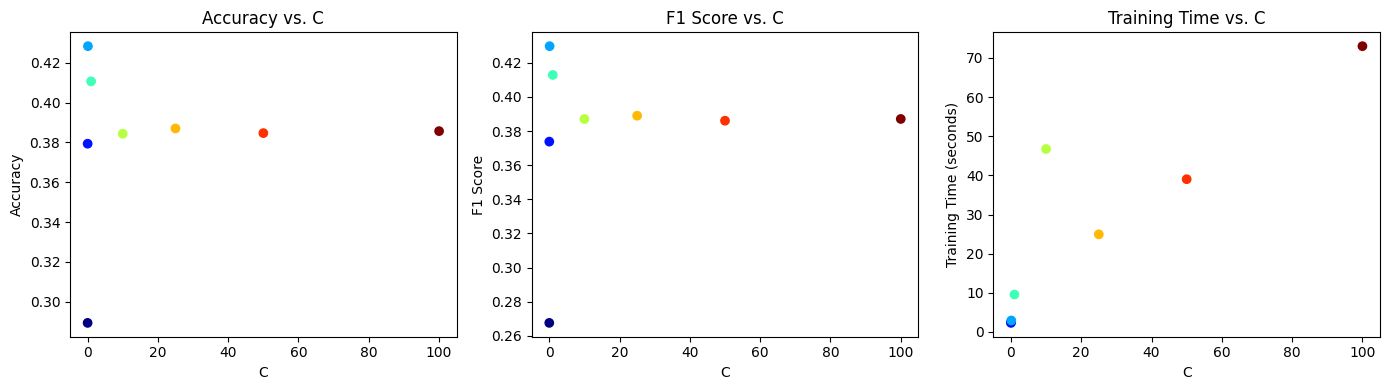

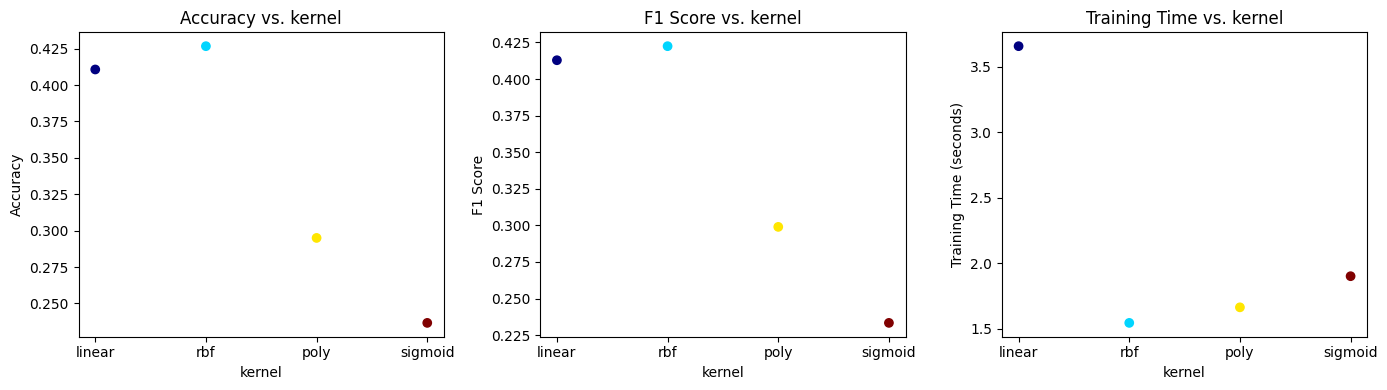

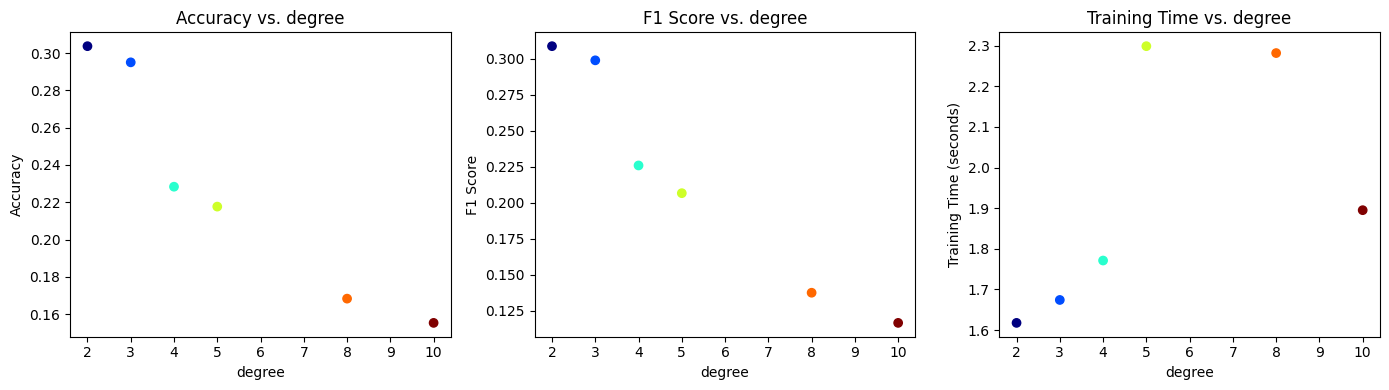

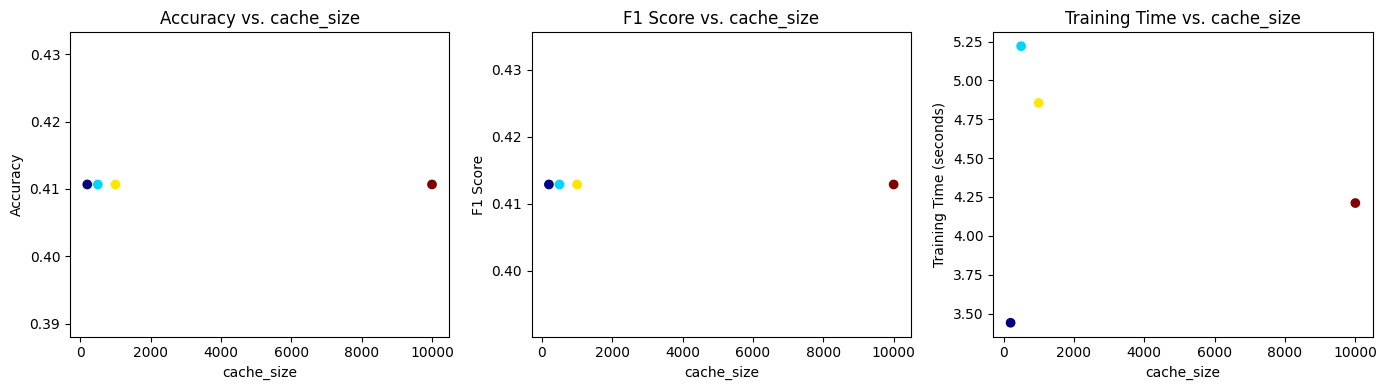

In [ ]:
hyperparameters = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 25.0, 50.0, 100.0],
                   'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                   'degree': [2, 3, 4, 5, 8, 10],
                   'cache_size':[200, 500, 1000, 10000]}

hyperparameter_variation_analysis(X_train_features_subset, y_train_features_subset, X_test_features_subset, y_test_features_subset, hyperparameters)

Hyperparameter Tuning

This process is used to find models with optimal classification metrics.

**Random Search**

In [ ]:
import pandas as pd
# Create an instance of SupportVectorMachineClassifier
svm_classifier = SupportVectorMachineClassifier()

# Define the parameter distributions for random search
param_distributions = {
    'C': [0.001 , 0.1, 1, 2, 5, 7, 10, 50, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 6, 10],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'cache_size':[200, 500, 1000, 10000]
}

# Perform random search for hyperparameter tuning
result = svm_classifier.tune_hyperparameters_random_search(X_train_features_subset, y_train_features_subset, param_distributions, n_iter= 50, cv=None)

# Retrain the model with the best hyperparameters
svm_classifier.retrain_with_best_params(X_train_features_subset, y_train_features_subset)

# Evaluate the classifier
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_features_subset, y_test_features_subset)

# Extract relevant fields from the random search results
result_df = pd.DataFrame(result)
selected_fields = [param for param in result_df.columns if param.startswith('param_')] + ['mean_fit_time', 'mean_score_time', 'mean_test_score']
result_df = result_df[selected_fields]

# Print the DataFrame
print(result_df)

# Specify the Excel file path
excel_file_path = 'random_search_features_results.xlsx'

# Save the DataFrame to an Excel file
result_df.to_excel(excel_file_path, index=False)

print(f"DataFrame has been saved to {excel_file_path}")

In [ ]:
# Create an instance of SupportVectorMachineClassifier
svm_classifier = SupportVectorMachineClassifier()

# Define the parameter distributions for random search
param_distributions = {
    'C': [0.001 , 0.1, 1, 2, 5, 7, 10, 50, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 6, 10],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'cache_size':[200, 500, 1000, 10000]
}

# Perform random search for hyperparameter tuning
result = svm_classifier.tune_hyperparameters_random_search(X_train_2d_subset, y_train_2d_subset, param_distributions, n_iter=50, cv=None)


# Retrain the model with the best hyperparameters
svm_classifier.retrain_with_best_params(X_train_2d_subset, y_train_2d_subset)

# Evaluate the classifier
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_2d_subset, y_test_2d_subset)

# Extract relevant fields from the random search results
result_df = pd.DataFrame(result)
selected_fields = [param for param in result_df.columns if param.startswith('param_')] + ['mean_fit_time', 'mean_score_time', 'mean_test_score']
result_df = result_df[selected_fields]

# Print the DataFrame
print(result_df)

# Specify the Excel file path
excel_file_path = 'random_search_images2d_results.xlsx'

# Save the DataFrame to an Excel file
result_df.to_excel(excel_file_path, index=False)

print(f"DataFrame has been saved to {excel_file_path}")

Best Hyperparameters (Random Search): {'tol': 0.001, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'cache_size': 500, 'C': 2}
	Accuracy: 0.42833333333333334
	Precision Weighted: 0.42739095860147464
	Recall Weighted: 0.42833333333333334
	F1-Score Weighted: 0.42479440613156405
   param_tol param_kernel param_gamma param_degree param_cache_size param_C  \
0     0.0001         poly        auto            2            10000       5   
1        0.1         poly        auto           10              200       7   
2     0.0001          rbf        auto           10            10000      10   
3     0.0001       linear        auto            6              500      10   
4       0.01       linear        auto            2             1000      10   
5        0.1         poly       scale           10              500     100   
6       0.01       linear       scale            6              500       2   
7      0.001          rbf       scale           10            10000       2   
8     0.0001

**Bayesian Optimization**

In [ ]:
# Create an instance of SupportVectorMachineClassifier
svm_classifier = SupportVectorMachineClassifier()

# Define the search space for Bayesian Optimization
search_spaces = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': (1e-6, 1e+1, 'log-uniform'),
    'degree': (1, 5),
    'tol': (1e-6, 1e-1, 'log-uniform'),
    'cache_size' : ([200, 500, 1000, 5000, 10000])
}

# Perform Bayesian Optimization for hyperparameter tuning
result = svm_classifier.tune_hyperparameters_bayesian_optimization(X_train_features_subset, y_train_features_subset, search_spaces, n_iter=50, cv=None)

# Retrain the model with the best hyperparameters
svm_classifier.retrain_with_best_params(X_train_features_subset, y_train_features_subset)

# Evaluate the classifier on the test set
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_features_subset, y_test_features_subset)

# Extract relevant fields from the random search results
result_df = pd.DataFrame(result)
selected_fields = [param for param in result_df.columns if param.startswith('param_')] + ['mean_fit_time', 'mean_score_time', 'mean_test_score']
result_df = result_df[selected_fields]

# Print the DataFrame
print(result_df)

# Specify the Excel file path
excel_file_path = 'bayes_search_features_results.xlsx'

# Save the DataFrame to an Excel file
result_df.to_excel(excel_file_path, index=False)

print(f"DataFrame has been saved to {excel_file_path}")

Best Hyperparameters (Bayesian Optimization): OrderedDict([('C', 9.834336244648368), ('cache_size', 200), ('degree', 3), ('gamma', 0.0061175198246625285), ('kernel', 'rbf'), ('tol', 8.83129264453997e-05)])
	Accuracy: 0.4646666666666667
	Precision Weighted: 0.4673773064040533
	Recall Weighted: 0.4646666666666667
	F1-Score Weighted: 0.4633304290803213
          param_C param_cache_size param_degree param_gamma param_kernel  \
0        0.839252             5000            2    0.010356         poly   
1   283123.556051             5000            3    0.001625       linear   
2         3.03264            10000            1     7.62693         poly   
3    73937.616624             5000            1    0.000002         poly   
4   149584.203673              200            2    0.000104         poly   
5   162913.875725              200            2    0.000305       linear   
6       261.94336              200            2    0.001252          rbf   
7       20.431504             5000      

In [ ]:
import pandas as pd
# Create an instance of SupportVectorMachineClassifier
svm_classifier = SupportVectorMachineClassifier()

# Define the search space for Bayesian Optimization
search_spaces = {
    'C': (1e-6, 1e+2, 'log-uniform'),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': (1, 5),
    'tol': (1e-6, 1e-1, 'log-uniform')
}

# Perform Bayesian Optimization for hyperparameter tuning
result = svm_classifier.tune_hyperparameters_bayesian_optimization(X_train_2d_subset, y_train_2d_subset, search_spaces, n_iter=10, cv=None)

# Retrain the model with the best hyperparameters
svm_classifier.retrain_with_best_params(X_train_2d_subset, y_train_2d_subset)

# Evaluate the classifier on the test set
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_2d_subset, y_test_2d_subset)

# Extract relevant fields from the random search results
result_df = pd.DataFrame(result)
selected_fields = [param for param in result_df.columns if param.startswith('param_')] + ['mean_fit_time', 'mean_score_time', 'mean_test_score']
result_df = result_df[selected_fields]

# Print the DataFrame
print(result_df)

# Specify the Excel file path
excel_file_path = 'bayes_search_images2d_results.xlsx'

# Save the DataFrame to an Excel file
result_df.to_excel(excel_file_path, index=False)

print(f"DataFrame has been saved to {excel_file_path}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters (Bayesian Optimization): OrderedDict([('C', 0.016314926491160914), ('degree', 3), ('gamma', 'scale'), ('kernel', 'linear'), ('tol', 5.7695068308136675e-06)])
	Accuracy: 0.36433333333333334
	Precision Weighted: 0.3668240305699224
	Recall Weighted: 0.36433333333333334
	F1-Score Weighted: 0.36304032921730806
     param_C param_degree param_gamma param_kernel param_tol  mean_fit_time  \
0  

In [ ]:
from google.colab import files

files.download(excel_file_path)

Using more examples/samples in the training set now

In [ ]:
import pandas as pd
# Create an instance of SupportVectorMachineClassifier
svm_classifier = SupportVectorMachineClassifier()

# Define the parameter distributions for random search
param_distributions = {
    'C': [0.001 , 0.1, 1, 2, 5, 7, 10, 50, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 6, 10],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

# Perform random search for hyperparameter tuning
result = svm_classifier.tune_hyperparameters_random_search(X_train_features_subset, y_train_features_subset, param_distributions, n_iter= 15, cv=None)

# Retrain the model with the best hyperparameters
svm_classifier.retrain_with_best_params(X_train_features_subset, y_train_features_subset)

# Evaluate the classifier
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_features_subset, y_test_features_subset)

# Extract relevant fields from the random search results
result_df = pd.DataFrame(result)
selected_fields = [param for param in result_df.columns if param.startswith('param_')] + ['mean_fit_time', 'mean_score_time', 'mean_test_score']
result_df = result_df[selected_fields]

# Print the DataFrame
print(result_df)

# Specify the Excel file path
excel_file_path = 'random_search_more_samples_features_results.xlsx'

# Save the DataFrame to an Excel file
result_df.to_excel(excel_file_path, index=False)

print(f"DataFrame has been saved to {excel_file_path}")

Best Hyperparameters (Random Search): {'tol': 0.1, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 10}
	Accuracy: 0.5454
	Precision Weighted: 0.5473725349116288
	Recall Weighted: 0.5454
	F1-Score Weighted: 0.5446198283575876
   param_tol param_kernel param_gamma param_degree param_C  mean_fit_time  \
0     0.0001       linear       scale            6       2     198.219339   
1     0.0001       linear        auto           10       7     899.767725   
2     0.0001       linear       scale           10       5     637.632920   
3        0.1         poly        auto           10      50      34.511948   
4        0.1       linear       scale            3   0.001      25.882160   
5      0.001          rbf       scale            4       5      30.607779   
6      0.001         poly        auto            3     100      29.980196   
7        0.1       linear        auto            3       1      30.641458   
8     0.0001       linear        auto            2      10    1414.861869   
9

In [ ]:
import pandas as pd
# Create an instance of SupportVectorMachineClassifier
svm_classifier = SupportVectorMachineClassifier()

# Define the parameter distributions for random search
param_distributions = {
    'C': [0.001 , 0.1, 1, 2, 5, 7, 10, 50, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 6, 10],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

# Perform random search for hyperparameter tuning
result = svm_classifier.tune_hyperparameters_random_search(X_train_features, y_train, param_distributions, n_iter= 5, cv=None)

# Retrain the model with the best hyperparameters
svm_classifier.retrain_with_best_params(X_train_features, y_train)

# Evaluate the classifier
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_features, y_test)

# Extract relevant fields from the random search results
result_df = pd.DataFrame(result)
selected_fields = [param for param in result_df.columns if param.startswith('param_')] + ['mean_fit_time', 'mean_score_time', 'mean_test_score']
result_df = result_df[selected_fields]

# Print the DataFrame
print(result_df)

# Specify the Excel file path
excel_file_path = 'random_search_more_samples_features_results.xlsx'

# Save the DataFrame to an Excel file
result_df.to_excel(excel_file_path, index=False)


**Searching for the effect of the Number of Features in the Performance and Time of SVM**

Additional search where I reduce the dimensionality of my dataset using specific number of features. I check how the different number of features affect the performance and training of classifiers on features using NonLinear Kernel

PCA Components: 10, Accuracy: 0.2890, Training Time: 0.6174
PCA Components: 20, Accuracy: 0.3080, Training Time: 1.0552
PCA Components: 50, Accuracy: 0.3470, Training Time: 1.1269
PCA Components: 75, Accuracy: 0.3807, Training Time: 1.0119
PCA Components: 100, Accuracy: 0.4163, Training Time: 0.8632
PCA Components: 200, Accuracy: 0.4433, Training Time: 1.2550
PCA Components: 242, Accuracy: 0.4520, Training Time: 1.4382


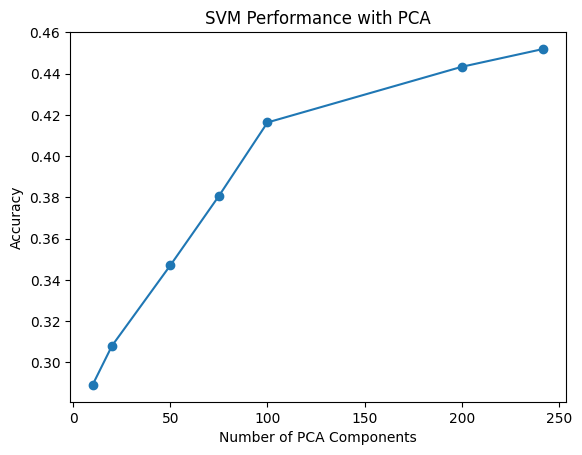

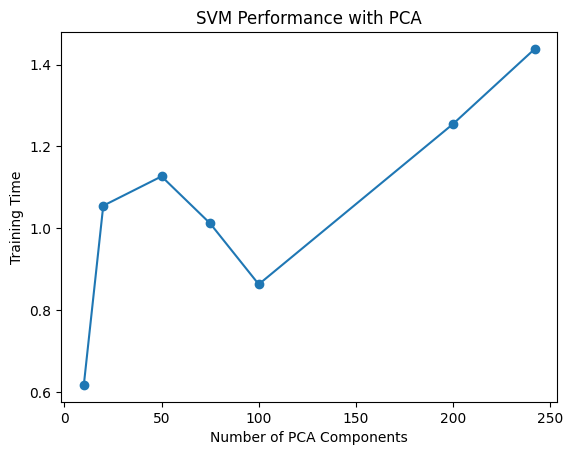

In [ ]:
def evaluate_linear_svm(X_train, X_test, y_train, y_test, n_components):
    accuracies = []
    times = []
    for n in n_components:

        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        svm_classifier = SupportVectorMachineClassifier(kernel='linear', C=0.1)

        start_time = time.time()
        svm_classifier.fit(X_train_pca, y_train)
        end_time = time.time()

        y_pred = svm_classifier.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append((n, accuracy))
        times.append(end_time-start_time)

    return accuracies,times


def evaluate_nonlinear_svm(X_train, X_test, y_train, y_test, n_components):
    accuracies = []
    times = []
    for n in n_components:

        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        svm_classifier = SupportVectorMachineClassifier(kernel='rbf', C=10)

        start_time = time.time()
        svm_classifier.fit(X_train_pca, y_train)
        end_time = time.time()

        y_pred = svm_classifier.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append((n, accuracy))
        times.append(end_time-start_time)

    return accuracies,times


n_components_list = [10, 20, 50, 75, 100, 200, 242]


results,times = evaluate_linear_svm(X_train_features_subset, X_test_features_subset, y_train_features_subset, y_test_features_subset, n_components_list)


for i in range(len(results)):
    result = results[i]
    print(f"PCA Components: {result[0]}, Accuracy: {result[1]:.4f}, Training Time: {times[i]:.4f}")


fig, ax = plt.subplots()
components, accuracies = zip(*results)
ax.plot(components, accuracies, marker='o')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Accuracy')
ax.set_title('SVM Performance with PCA')
plt.show()


fig, ax = plt.subplots()
ax.plot(components, times, marker='o')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Training Time')
ax.set_title('SVM Performance with PCA')
plt.show()

Checking how the different number of features affect the performance and training of classifiers on features using NonLinear Kernel

PCA Components: 10, Accuracy: 0.3327, Training Time: 0.8240
PCA Components: 20, Accuracy: 0.3587, Training Time: 0.9316
PCA Components: 50, Accuracy: 0.3850, Training Time: 1.2103
PCA Components: 75, Accuracy: 0.4187, Training Time: 1.4240
PCA Components: 100, Accuracy: 0.4400, Training Time: 1.2758
PCA Components: 200, Accuracy: 0.4640, Training Time: 1.8571
PCA Components: 242, Accuracy: 0.4620, Training Time: 2.4049


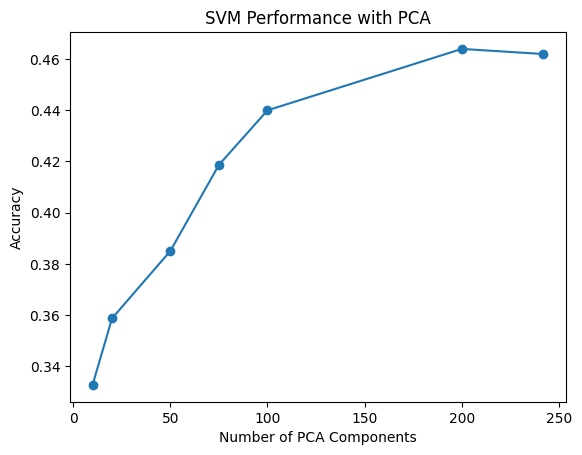

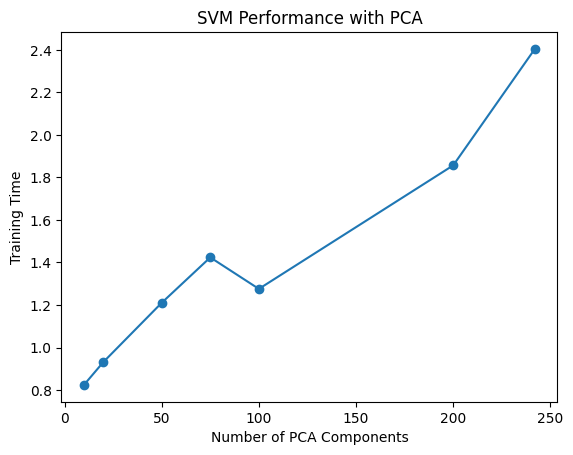

In [ ]:
results,times = evaluate_nonlinear_svm(X_train_features_subset, X_test_features_subset, y_train_features_subset, y_test_features_subset, n_components_list)

for i in range(len(results)):
    result = results[i]
    print(f"PCA Components: {result[0]}, Accuracy: {result[1]:.4f}, Training Time: {times[i]:.4f}")

fig, ax = plt.subplots()
components, accuracies = zip(*results)
ax.plot(components, accuracies, marker='o')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Accuracy')
ax.set_title('SVM Performance with PCA')
plt.show()

fig, ax = plt.subplots()
ax.plot(components, times, marker='o')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Training Time')
ax.set_title('SVM Performance with PCA')
plt.show()

Checking how the different number of features affect the performance and training of classifiers on 2d image data

PCA Components: 10, Accuracy: 0.3440, Training Time: 0.8288
PCA Components: 20, Accuracy: 0.4010, Training Time: 1.1389
PCA Components: 50, Accuracy: 0.4050, Training Time: 1.0261
PCA Components: 75, Accuracy: 0.4220, Training Time: 1.2398
PCA Components: 100, Accuracy: 0.4223, Training Time: 1.2627
PCA Components: 200, Accuracy: 0.4270, Training Time: 1.8648


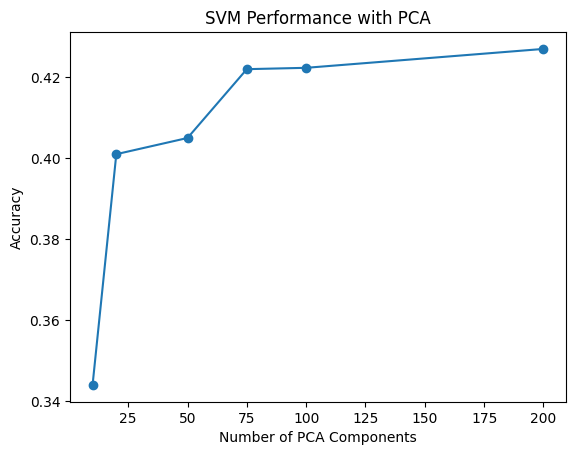

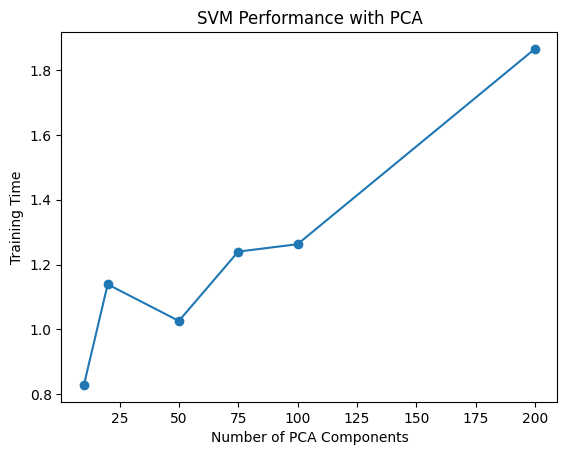

In [ ]:
n_components_list = [10, 20, 50, 75, 100, 200]

results,times = evaluate_nonlinear_svm(X_train_2d_subset, X_test_2d_subset, y_train_2d_subset, y_test_2d_subset, n_components_list)

for i in range(len(results)):
    result = results[i]
    print(f"PCA Components: {result[0]}, Accuracy: {result[1]:.4f}, Training Time: {times[i]:.4f}")

fig, ax = plt.subplots()
components, accuracies = zip(*results)
ax.plot(components, accuracies, marker='o')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Accuracy')
ax.set_title('SVM Performance with PCA')
plt.show()

fig, ax = plt.subplots()
ax.plot(components, times, marker='o')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Training Time')
ax.set_title('SVM Performance with PCA')
plt.show()

# Specific Pipelines & Architectures that use SVM Classification Power and showed impressive performance

In this section a further exploration is performed with different architectures or hyperparameters that showed impressive performance.

In [ ]:
svm_classifier= SupportVectorMachineClassifier(tol = 0.001,kernel='rbf',gamma='auto',C=2)
start_time = time.time()
svm_classifier.fit(X_train_2d, y_train)
end_time = time.time()
print("Training time: ", end_time - start_time)
print("------------- Evaluation Metrics-----------------")
evaluation_results = svm_classifier.evaluate_classification_metrics(X_test_2d, y_test)

Training time:  612.5621812343597
------------- Evaluation Metrics-----------------
	Accuracy: 0.5579
	Precision Weighted: 0.5577951612228739
	Recall Weighted: 0.5579
	F1-Score Weighted: 0.5569815667123416


In the following cells, ensemble architectures were tested. The ensembles did not contributed to increased performance. However, their complexity is increased.

**Bagging Classifier**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
svm_model = SVC()
random_forest_svm = BaggingClassifier(estimator=svm_model, n_estimators=10) # Initializing a bagging classifier with 10 base models
random_forest_svm.fit(X_train_features_subset, y_train_features_subset)
accuracy = random_forest_svm.score(X_test_features_subset, y_test_features_subset)

print(f"Random Forest with SVM base model accuracy: {accuracy}")

Random Forest with SVM base model accuracy: 0.42966666666666664


**Stacking Classifier**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

# Create an SVM base model
svm_model1 = SVC(kernel='rbf')
svm_model2 = SVC(kernel='linear')

# Create a StackingClassifier with SVM as the base model
stacking_svm = StackingClassifier(
    estimators=[('svm1', svm_model1),('svm2', svm_model2)], # Stacking 2 classifiers
)

# Fit the model
stacking_svm.fit(X_train_features_subset, y_train_features_subset)

# Evaluate the model
accuracy = stacking_svm.score(X_test_features_subset, y_test_features_subset)
print(f"Stacking with SVM base model accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking with SVM base model accuracy: 0.46166666666666667


**Extracting Histograms of the GrayScale Images + PCA**

In [ ]:
import cv2
from tqdm import tqdm
from joblib import dump, load
from tensorflow import keras
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Preprocess the images after transforming the to Grayscale and remove
# colour related information
def preprocess(xs):
    hog_imgs = []
    for x in tqdm(xs):
        gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        fd = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                    	cells_per_block=(2, 2))
        hog_imgs.append(fd)
    return np.array(hog_imgs)


x_train = preprocess(X_train)
x_test = preprocess(X_test)

# Creating a pipeline to test the Architecture easier
pipe = Pipeline([('pca', PCA(0.95)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))])
y_train_1d = y_train.reshape(-1)
y_test_1d = y_test.reshape(-1)
start_time = time.time()
pipe.fit(x_train, y_train_1d)
end_time = time.time()
y_pred = pipe.predict(x_test)
print("Training time: ", end_time - start_time)
print("------------- Evaluation Metrics-----------------")
metrics = evaluate_classification_metrics(y_test_1d, y_pred)

100%|██████████| 10000/10000 [00:05<00:00, 1852.79it/s]


Training time:  480.8322448730469
------------- Evaluation Metrics-----------------
	Accuracy: 0.6269
	Precision Weighted: 0.6271680232701461
	Recall Weighted: 0.6269
	F1-Score Weighted: 0.6264498646694696


**Classifier using part of the extracted features + PCA**

This classifier proved to showcase the best metrics.

In [ ]:
# Create a function that calculates only the histograms of oriented gradients
def extract_hog_features(X, channel_axis=-1):
    hog_features = []
    for i in range(X.shape[0]):
        image = X[i]
        hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)
        hog_features.append(hog_image)

    return np.array(hog_features)

# Extracting these specific features on the initial dataset -> using all the information(samples) for the final model
x_train = extract_hog_features(X_train)
x_test = extract_hog_features(X_test)
y_train_1d = y_train.reshape(-1)
y_test_1d = y_test.reshape(-1)

# Creating a pipeline to test the Architecture easier
pipe = Pipeline([('pca', PCA(0.95)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))]) # simple pipeline with a PCA and SVM classifier.
start_time = time.time()
pipe.fit(x_train, y_train_1d)
end_time = time.time()
# Save the best pipeline
dump(pipe, 'pipe.joblib')
# Make predictions
y_pred = pipe.predict(x_test)
# print metrics + time
print("Training time of Best Model: ", end_time - start_time)
print("------------- Evaluation Metrics-----------------")
metrics = evaluate_classification_metrics(y_test_1d, y_pred)

Training time of Best Model:  671.6962416172028
------------- Evaluation Metrics-----------------
	Accuracy: 0.6518
	Precision Weighted: 0.6509328507401269
	Recall Weighted: 0.6518
	F1-Score Weighted: 0.6509043389167024


Constuction of Hybrid CNN + SVM. One of the models tested is presented below. The results showed that the performance of the CNN networks implemented in the First Assignment were not improved usign a SVM classifier at the end. However, similar accuracies could be reached using this hybrid model.

In [ ]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Loading data again
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# CNN model
input_layer = Input(shape=(32, 32, 3))
conv1 = Conv2D(224, (3, 3), activation='relu', padding='same')(input_layer)
conv2 = Conv2D(224, (3, 3), activation='relu', padding='same')(conv1)
maxpool1 = MaxPooling2D((2, 2))(conv2)
dropout1 = Dropout(0.25)(maxpool1)

conv3 = Conv2D(224, (3, 3), activation='relu', padding='same')(dropout1)
maxpool2 = MaxPooling2D((2, 2))(conv3)
dropout2 = Dropout(0.25)(maxpool2)

# conv4 = Conv2D(224, (3, 3), activation='relu', padding='same')(dropout2)
# maxpool3 = MaxPooling2D((2, 2))(conv4)
# dropout3 = Dropout(0.25)(maxpool3)

# conv5 = Conv2D(224, (3, 3), activation='relu', padding='same')(dropout3)
# maxpool4 = MaxPooling2D((2, 2))(conv5)
# dropout4 = Dropout(0.25)(maxpool4)

flatten = Flatten()(dropout2)
dense1 = Dense(384, activation='relu')(flatten)
dropout5 = Dropout(0.5)(dense1)
output = Dense(10, activation='softmax')(dropout5)

# Create a model for feature extraction
feature_extraction_model = Model(inputs=input_layer, outputs=dropout2)

# Create the complete CNN model
cnn_model = Model(inputs=input_layer, outputs=output)

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Extract features from the CNN
cnn_features_train = feature_extraction_model.predict(x_train)
cnn_features_test = feature_extraction_model.predict(x_test)

# Flatten the features
cnn_features_train = cnn_features_train.reshape(cnn_features_train.shape[0], -1)
cnn_features_test = cnn_features_test.reshape(cnn_features_test.shape[0], -1)

# Train an SVM on the extracted features
svm_model = SVC(kernel='linear')
svm_model.fit(cnn_features_train, np.argmax(y_train, axis=1))


svm_predictions = svm_model.predict(cnn_features_test)


accuracy = accuracy_score(np.argmax(y_test, axis=1), svm_predictions)
print("Accuracy:", accuracy)

# Small Investigation of Other Libraries

In [ ]:
from sklearn.svm import LinearSVC # Scalable Linear Support Vector Machine for classification implemented using liblinear
# # The main differences between LinearSVC and SVC lie in the loss function used by default, and in the handling of intercept regularization between those two implementations.

class LinearSVM(object):
    def __init__(self, C=1.0, loss='hinge', multi_class='ovr', max_iter=1000):
        self.C = C
        self.loss = loss
        self.multi_class = multi_class
        self.max_iter = max_iter
        self.svm =  LinearSVC(loss=self.loss, multi_class=self.multi_class, C=self.C, max_iter=self.max_iter)

    def train(self, X_train, y_train):
        start_time = time.time()
        self.svm.fit(X_train, y_train)
        end_time =  time.time()
        print("Elapsed time {:.2f} seconds".format(end_time -  start_time))

    def pred(self,X_test):
        prediction = self.svm.predict(X_test)
        return prediction

Checking the libsvm documentation according to the source given in the 2nd assignment.

In [ ]:
!pip install -U libsvm-official

from libsvm.svmutil import *

param = svm_parameter('-t 0 -c 4 -b 1')
prob  = svm_problem(y_train_flatten_subset, X_train_2d_subset)
m = svm_train(prob, param)
p_label, p_acc, p_val = svm_predict(y_test_flatten, X_test_2d, m, '-b 1')

  Preparing metadata (setup.py) ... done
  Created wheel for libsvm-official: filename=libsvm_official-3.32.0-cp310-cp310-linux_x86_64.whl size=123883 sha256=4e320fbaa25516c38901bf9d4de60545e92dc640d8c8f0c72b149dcd84bd4bb3
  Stored in directory: /root/.cache/pip/wheels/61/3b/1b/73bb4869517f96a26c82b47ccdb9ec48f12f4466de2371eff6
Successfully built libsvm-official
